In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler

**Objetive**
+ Knowing the distribution of customers, in order to suggest policies or interventions..    

**Analysis**  
+ ETL & EDA of the data 

**Segmentation RMF** 
+ Customer segmentation
+ Study customer segments


# ETL

## Data loading

In [2]:
df = pd.read_csv('https://github.com/IEXE-Tec/mcda-marketing/blob/main/OnlineRetail.csv.zip?raw=true', encoding='latin1',compression='zip')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## NaN, missing, infs

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
initial_shape = df.shape
initial_shape

(541909, 8)

#### Columns with NaNs

In [6]:
df.isna().any(axis=0)

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [7]:
df.loc[:,df.isna().any(axis=0)].head()

,Description,CustomerID
0,WHITE HANGING HEART T-LIGHT HOLDER,17850.0
1,WHITE METAL LANTERN,17850.0
2,CREAM CUPID HEARTS COAT HANGER,17850.0
3,KNITTED UNION FLAG HOT WATER BOTTLE,17850.0
4,RED WOOLLY HOTTIE WHITE HEART.,17850.0


NaN's are only in the Description and CustomerID columns.

#### Rows with NaNs

In [8]:
print('Total of rows with nans:  ', df[df.isna().any(axis=1)].shape[0])
df[df.isna().any(axis=1)].head(2)

Total of rows with nans:   135080


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom


#### NaNs in Description   


Note that there are very few NaNs in the product description.

In [9]:
df[df['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


We also note that they are not priced. Although it would be convenient to do more research, for now we can eliminate them from the base, because the percentage is small and they can complicate the analysis.

In [10]:
df[df['Description'].isna()]['UnitPrice'].sum()

0.0

In [11]:
df = df[~df['Description'].isna()]

In [12]:
print('Data deleted: {}'.format(initial_shape[0]-df.shape[0]))
df.shape

Data deleted: 1454


(540455, 8)

#### NaNs in CustomerID    



In [13]:
def miss_values():
    missing_values = df.isnull().sum().to_frame().reset_index()
    missing_values = missing_values.rename(columns={'index': 'Feature', 0: 'Empty Cells'})
    missing_values['Percentage %'] = (missing_values['Empty Cells']/df.shape[0])*100
    missing_values = missing_values.sort_values(by='Empty Cells', ascending=False)
    return missing_values

In [14]:
miss_values()

,Feature,Empty Cells,Percentage %
6,CustomerID,133626,24.724723
0,InvoiceNo,0,0.000000
1,StockCode,0,0.000000
2,Description,0,0.000000
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
7,Country,0,0.000000


There are many missings in the CustomerID about 25% of the base are NaNs. This may be due to an error in the system, or because the buyer did not create an account. 
+ We could remove them from the base, but since they represent about 25% it is better to keep them.  
+ We could create a specific id for all these buyers, for example a negative id to make it easy to remember when modeling or manipulating.

In [15]:
df[df['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [16]:
# Let's check if out of the missings the ids are integers or negatives
customer_id = df.loc[~df['CustomerID'].isna(), 'CustomerID'].unique()
customer_id = customer_id.astype(int)
(customer_id < 0).sum()

0

In [17]:
customer_id

array([17850, 13047, 12583, ..., 13298, 14569, 12713])

We can handle the CustomerIDs as ints, and assign the -1 to the customers that have no ID without any problem, since no others have a negative number.

In [18]:
df.loc[df['CustomerID'].isna(), 'CustomerID'] = -1
df['CustomerID'] = df['CustomerID'].astype(int) 
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom


Como podemos obsrevar en la siguiente celda, no hay missings.

In [19]:
df[df.isna().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [20]:
miss_values()

,Feature,Empty Cells,Percentage %
0,InvoiceNo,0,0.0
1,StockCode,0,0.0
2,Description,0,0.0
3,Quantity,0,0.0
4,InvoiceDate,0,0.0
5,UnitPrice,0,0.0
6,CustomerID,0,0.0
7,Country,0,0.0


### Data type

In [21]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       int32
Country         object
dtype: object

Let's convert the corresponding columns to date type

In [22]:
df['date'] = pd.to_datetime(df['InvoiceDate'])
# Let's create a time stampt to represent the month and year (in this case it will be the end of the month).
df['year_month'] = df['date'].map(lambda x: x.to_period('M').to_timestamp('M'))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31


In [23]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate            object
UnitPrice             float64
CustomerID              int32
Country                object
date           datetime64[ns]
year_month     datetime64[ns]
dtype: object

In [24]:
df[~df['InvoiceNo'].str.isnumeric()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom,2010-12-01 09:41:00,2010-12-31
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom,2010-12-01 09:49:00,2010-12-31
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397,United Kingdom,2011-12-09 09:57:00,2011-12-31
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498,United Kingdom,2011-12-09 10:28:00,2011-12-31
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311,United Kingdom,2011-12-09 11:57:00,2011-12-31
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315,United Kingdom,2011-12-09 11:58:00,2011-12-31


The InvoiceNo column cannot be handled directly as an integer, it has to be a string. We could make a dictionary of the columns with strings to ints to improve memory usage if desired.

In [25]:
#df['InvoiceNo'] = df['InvoiceNo'].apply(lambda x: str(x).replace('C', ''))
#df['InvoiceNo'] = df['InvoiceNo'].apply(lambda x: str(x).replace('A', ''))
#df['InvoiceNo'] = df['InvoiceNo'].astype(int)
#df.dtypes

## Summary ETL

It seems that the data are in good condition, except for the missings in the customer id that may be due to several causes and represent about 2% of the total database. To solve the problem, we assign them the number -1.

# Initial EDA

The objective is to segment (cluster) the customers, but also to verify the quality of the data, as this is the first EDA I have performed on them.

One of the most important metrics for online df:
+  **monthly revenue**.

## EDA data exploration

In [26]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,540455.000000,540455.000000,540455.000000
mean,9.603129,4.623519,11507.604224
std,218.007598,96.889628,6761.212883
min,-80995.000000,-11062.060000,-1.000000
25%,1.000000,1.250000,12367.000000
50%,3.000000,2.080000,14390.000000
75%,10.000000,4.130000,16261.000000
max,80995.000000,38970.000000,18287.000000


Note that there are negative quantities and negative prices. Could they be returns?

### Price

In [27]:
df[df['UnitPrice']<0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,-1,United Kingdom,2011-08-12 14:51:00,2011-08-31
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,-1,United Kingdom,2011-08-12 14:52:00,2011-08-31


From the description we can infer that they are account adjustments, given the amount of sales, we can eliminate it without causing too much trouble.

In [28]:
df = df[~(df['UnitPrice']<0.0)]

### Quantity

In [29]:
df[df['Quantity']<0.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom,2010-12-01 09:41:00,2010-12-31
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom,2010-12-01 09:49:00,2010-12-31
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom,2010-12-01 10:24:00,2010-12-31
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397,United Kingdom,2011-12-09 09:57:00,2011-12-31
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498,United Kingdom,2011-12-09 10:28:00,2011-12-31
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311,United Kingdom,2011-12-09 11:57:00,2011-12-31
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315,United Kingdom,2011-12-09 11:58:00,2011-12-31


In this case it seems that there is nothing to infer what happened, so we can infer that they are **devolutions**. 

### CustumerID

In [30]:
print('Number of unique clients:  ',len(df['CustomerID'].unique()))

Number of unique clients:   4373


### StockCode and Description

In [31]:
print('Number of unique StockCode:  ',len(df['StockCode'].unique()))

Number of unique StockCode:   3958


In [32]:
print('Number of unique Description:  ',len(df['Description'].unique()))

Number of unique Description:   4223


In [33]:
df['Description'].unique()[np.random.randint(len(df['Description'].unique()), size=20)]

array(['FLYING PIG WATERING CAN', 'CANDY SPOT HEART DECORATION',
       'BISCUIT TIN VINTAGE GREEN', 'HEAVENS SCENT FRAGRANCE OILS ASSTD',
       'LIGHTHOUSE PRINTED METAL SIGN',
       'AMBER FINE BEAD NECKLACE W TASSEL', 'VINTAGE GLASS TEA CADDY',
       'AMAZON', 'PAPER CHAIN KIT LONDON', 'PINK BUNNY EASTER EGG BASKET',
       'JARDIN ETCHED GLASS BUTTER DISH', 'SNACK TRAY PAISLEY PARK',
       'COSY SLIPPER SHOES SMALL  RED ', 'TRAVEL CARD WALLET KEEP CALM',
       'WALL ART VINTAGE HEART', 'TWO DOOR CURIO CABINET',
       'BLUE  TILE HOOK', 'CHILDS GARDEN BRUSH BLUE',
       'BUBBLEGUM RING ASSORTED', 'COCKTAIL SWORDS 50 PIECES'],
      dtype=object)

Note that the stockcode and the description don't have the same number. Let's investigate a little more.

In [34]:
df[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')

,StockCode,Description
31,10002,INFLATABLE POLITICAL GLOBE
103332,10080,GROOVY CACTUS INFLATABLE
454350,10080,check
5452,10120,DOGGY RUBBER
5451,10123C,HEARTS WRAPPING TAPE
...,...,...
228807,gift_0001_20,to push order througha s stock was
44725,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
38248,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
42057,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00


In [35]:
r_ = df[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')
r_[r_.duplicated(subset='StockCode', keep=False)]

,StockCode,Description
103332,10080,GROOVY CACTUS INFLATABLE
454350,10080,check
741,10133,COLOURING PENCILS BROWN TUBE
474647,10133,damaged
192289,15058A,wet/rusty
...,...,...
24906,DCGS0003,BOXED GLASS ASHTRAY
279254,DCGS0069,ebay
75053,DCGS0069,OOH LA LA DOGS COLLAR
44794,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00


Note how a single StockCode (i.e. 10080) belongs to several descriptions. Therefore it is convenient to use description as sales product, especially for the first iteration. Then I could create a dictionary or table to fix these problems.

**Note**: It appears that the products that are written in lower case are 'rare' or anomalous. For example they have adjectives (wet/rusty), are gift vouchers (Dotcomgiftshop Gift Voucher £20.00), or miscellaneous things (to push order througha s stock was). We could also clean up the data for these products, but given the small amount they represent and being the first iteration I can skip it.

### InvoiceNo

InvoiceNo is the purchase or transaction number, so that a person who buys several products, but in one purchase I will see them under the same InvoiceNo.

In [36]:
print('Number of InvoiceNo unique:  ',len(df['InvoiceNo'].unique()))

Number of InvoiceNo unique:   24444


In [37]:
df[['InvoiceNo', 'CustomerID', 'Description']].sort_values('InvoiceNo')

,InvoiceNo,CustomerID,Description
0,536365,17850,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,17850,WHITE METAL LANTERN
2,536365,17850,CREAM CUPID HEARTS COAT HANGER
3,536365,17850,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,17850,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...
540449,C581490,14397,ZINC T-LIGHT HOLDER STARS SMALL
541541,C581499,15498,Manual
541715,C581568,15311,VICTORIAN SEWING BOX LARGE
541716,C581569,17315,HANGING HEART JAR T-LIGHT HOLDER


### Date

In [38]:
print('Min date ',df['date'].min())
print('Max date  ', df['date'].max())

Min date  2010-12-01 08:26:00
Max date   2011-12-09 12:50:00


Note that the data corresponds to a little more than a year, since the last month is not complete and I will probably make aggregations at the monthly level, it is convenient to remove it to avoid confusion.  
**Note: I could add the cutoff in the ETL part or here.

In [39]:
df.shape

(540453, 10)

In [40]:
df = df[df['date'] < pd.to_datetime('2011-12-01')]

In [41]:
df.shape

(514943, 10)

<Axes: xlabel='date', ylabel='indicadora'>

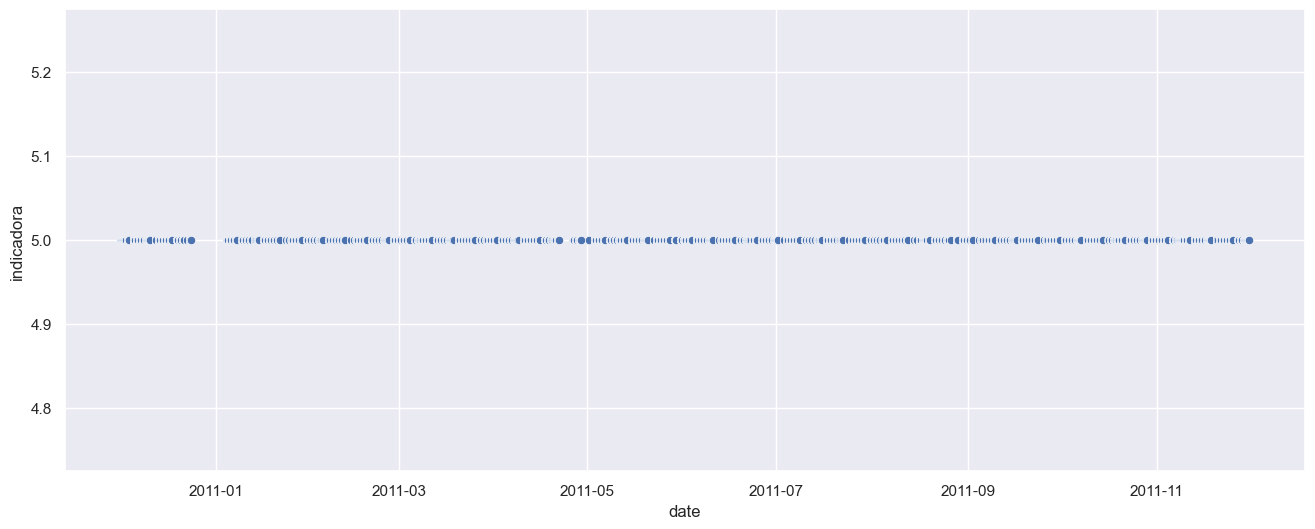

In [42]:
fechas = df[['date']].drop_duplicates()
fechas['indicadora'] = 5
sns.scatterplot(data=fechas, x='date', y='indicadora')

In [43]:
fechas

,date,indicadora
0,2010-12-01 08:26:00,5
7,2010-12-01 08:28:00,5
9,2010-12-01 08:34:00,5
25,2010-12-01 08:35:00,5
26,2010-12-01 08:45:00,5
...,...,...
516219,2011-11-30 17:32:00,5
516221,2011-11-30 17:34:00,5
516222,2011-11-30 17:37:00,5
516369,2011-11-30 17:39:00,5


### Country

In [44]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [45]:
df.groupby(['Country']).describe()

Quantity                                              \
                         count       mean         std      min   25%   50%   
Country                                                                      
Australia               1259.0  66.444003   97.686932   -120.0   6.0  24.0   
Austria                  394.0  11.875635   21.867337    -48.0   6.0   8.0   
Bahrain                   19.0  13.684211   30.016759    -54.0   5.0   6.0   
Belgium                 1971.0  11.189751   13.824811    -12.0   4.0  10.0   
Brazil                    32.0  11.125000    8.476723      2.0   3.0  10.0   
Canada                   151.0  18.298013   46.682587      1.0   6.0  12.0   
Channel Islands          752.0  12.526596   22.645343     -2.0   4.0  10.0   
Cyprus                   618.0  10.231392   23.319843    -33.0   2.0   5.0   
Czech Republic            30.0  19.733333   22.813990    -24.0  12.0  24.0   
Denmark                  378.0  21.203704   27.650975    -25.0  12.0  12.0   
EIRE                    7861.0  17.620913   41.155437   -288.0   4.0  10.0   
European Community        61.0   8.147541    6.546847     -2.0   3.0   6.0   
Finland                  681.0  15.149780   20.796801    -27.0   6.0  10.0   
France                  8218.0  13.001825   21.729008   -250.0   5.0  10.0   
Germany                 9155.0  12.399235   18.047675   -288.0   5.0  10.0   
Greece                   110.0  12.000000    8.229506     -1.0   6.0  12.0   
Hong Kong                288.0  16.559028   16.936343     -1.0   6.0  11.0   
Iceland                  171.0  13.251462   19.363426      2.0   6.0  12.0   
Israel                   297.0  14.656566   16.026474    -32.0   4.0  11.0   
Italy                    795.0  10.005031   13.630237    -12.0   4.0   6.0   
Japan                    350.0  72.191429  178.824210   -624.0   6.0  40.0   
Lebanon                   45.0   8.577778    4.314294      2.0   6.0   8.0   
Lithuania                 35.0  18.628571   10.137542      6.0  12.0  16.0   
Malta                    122.0   7.803279    8.017171     -4.0   3.0   6.0   
Netherlands             2285.0  84.100656  109.500128   -480.0  16.0  64.0   
Norway                  1013.0  16.710760   20.502344    -12.0   6.0  12.0   
Poland                   341.0  10.712610   10.174628     -6.0   4.0  10.0   
Portugal                1417.0  10.313338   10.894878    -12.0   3.0   8.0   
RSA                       58.0   6.068966    3.329096      1.0   3.0   6.0   
Saudi Arabia              10.0   7.500000    5.720334     -5.0   6.0   9.0   
Singapore                229.0  22.855895   27.742886     -1.0   8.0  12.0   
Spain                   2462.0  10.791227   24.421637   -288.0   3.0   6.0   
Sweden                   460.0  77.471739  129.044204   -240.0   8.0  20.0   
Switzerland             2002.0  15.147353   18.956901   -120.0   6.0  12.0   
USA                      248.0   2.524194   15.302332    -36.0 -10.0   4.0   
United Arab Emirates      68.0  14.441176   12.474909      1.0   6.0  12.0   
United Kingdom        470111.0   8.673379  162.592215 -74215.0   1.0   3.0   
Unspecified              446.0   7.399103    8.765735      1.0   1.0   3.0   

                                     UnitPrice              ...        \
                        75%      max     count        mean  ...   75%   
Country                                                     ...         
Australia              96.0   1152.0    1259.0    3.220612  ...  3.75   
Austria                12.0    288.0     394.0    4.154670  ...  4.15   
Bahrain                10.0     96.0      19.0    4.556316  ...  4.60   
Belgium                12.0    272.0    1971.0    3.686499  ...  4.15   
Brazil                 18.0     24.0      32.0    4.456250  ...  6.75   
Canada                 20.0    504.0     151.0    6.030331  ...  2.95   
Channel Islands        12.0    407.0     752.0    4.938431  ...  6.25   
Cyprus                 12.0    288.0     618.0    6.230939  ...  4.95   
Czech Republic      

## EDA Metrics

### Country   
This really should go in the ETL, but since I wanted to understand in a general way the content of the columns, I preferred to analyze it this way.

In [46]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [47]:
df2 = df[['Country', 'InvoiceNo']].drop_duplicates().groupby('Country').count().reset_index().sort_values(by='InvoiceNo', ascending=False)
df2.head(2)

,Country,InvoiceNo
36,United Kingdom,21131
14,Germany,581


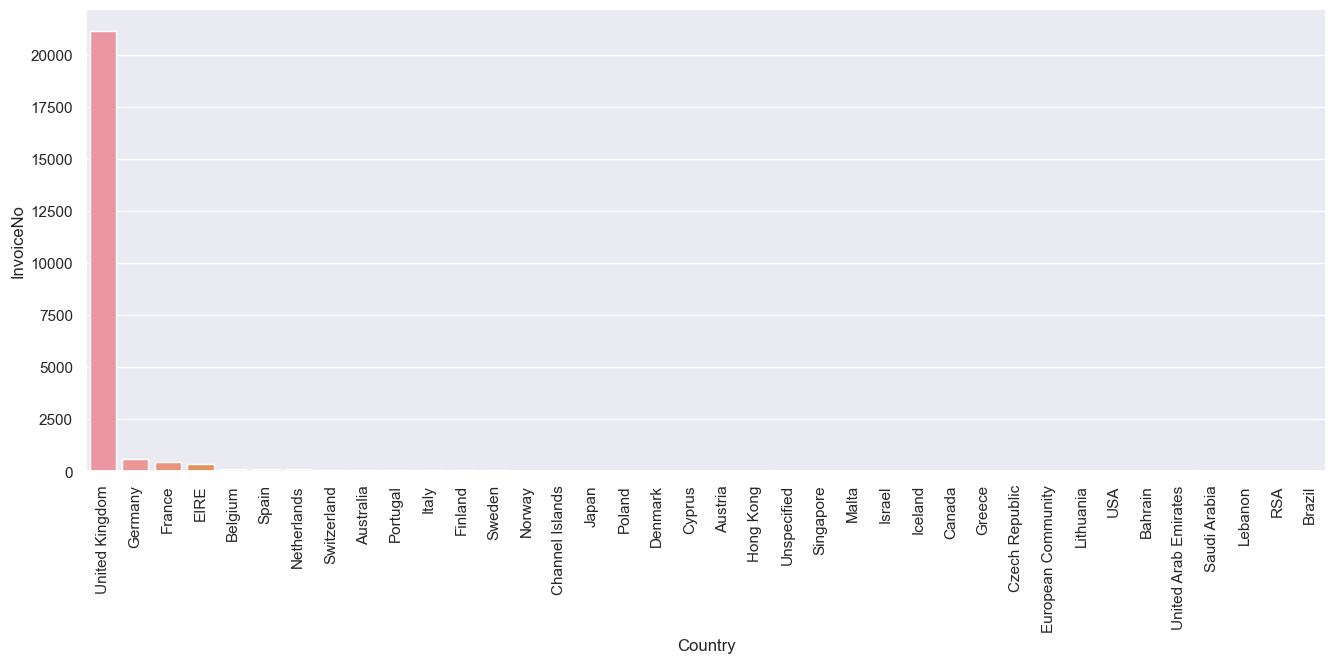

In [48]:
sns.barplot(data=df2, x='Country', y='InvoiceNo')
plt.xticks(rotation=90)
plt.show()

In [49]:
df[['Country', 'InvoiceNo']].drop_duplicates().groupby('Country', as_index=False)['InvoiceNo'].count().sort_values('InvoiceNo', ascending=False).head()

,Country,InvoiceNo
36,United Kingdom,21131
14,Germany,581
13,France,440
10,EIRE,348
3,Belgium,114


For ease of analysis I will concentrate on the UK only, as it has the most data (see cells below).

In [50]:
print(df.shape)
df = df[df['Country']=='United Kingdom']
print(df.shape)

(514943, 10)
(470111, 10)


## Insights generation

### Revenue

In [51]:
df['revenue'] =  df['UnitPrice'] * df['Quantity']
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34


### Monthly Revenue

<Axes: xlabel='year_month', ylabel='revenue'>

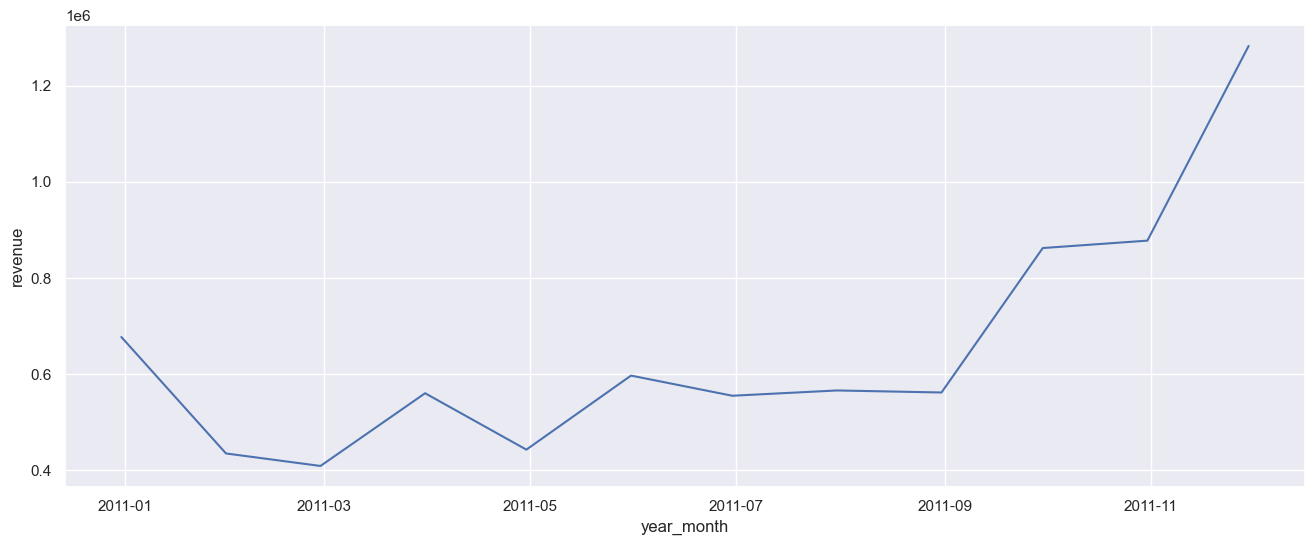

In [52]:
mrevenue = df.groupby('year_month', as_index=False)['revenue'].sum().sort_values('year_month', ascending=True)
sns.lineplot(data=mrevenue, x='year_month', y='revenue')

In [53]:
mrevenue

,year_month,revenue
0,2010-12-31,676742.620
1,2011-01-31,434308.300
2,2011-02-28,408247.910
3,2011-03-31,559707.390
4,2011-04-30,442254.041
5,2011-05-31,596459.860
6,2011-06-30,554478.350
7,2011-07-31,565479.841
8,2011-08-31,561254.620
9,2011-09-30,862018.152


### Monthly Revenue Growth

Let's see how much sales have grown month over month, this can help us detect patterns or anomalies.

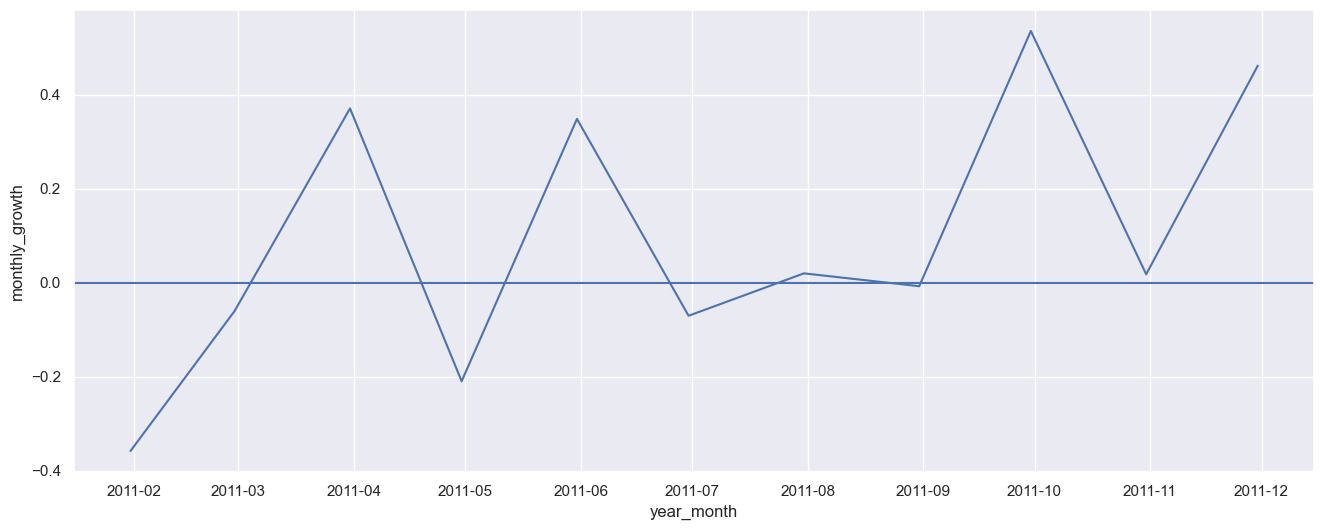

In [54]:
mrevenue['monthly_growth'] = mrevenue['revenue'].pct_change()
g = sns.lineplot(data=mrevenue, x='year_month', y='monthly_growth')
g.axhline(0.0)

In [55]:
mrevenue

,year_month,revenue,monthly_growth
0,2010-12-31,676742.620,NaN
1,2011-01-31,434308.300,-0.358237
2,2011-02-28,408247.910,-0.060004
3,2011-03-31,559707.390,0.370999
4,2011-04-30,442254.041,-0.209848
5,2011-05-31,596459.860,0.348682
6,2011-06-30,554478.350,-0.070384
7,2011-07-31,565479.841,0.019841
8,2011-08-31,561254.620,-0.007472
9,2011-09-30,862018.152,0.535877


### Monthly Orders

Let's see how many purchases/orders are made per month

<Axes: xlabel='year_month', ylabel='InvoiceNo'>

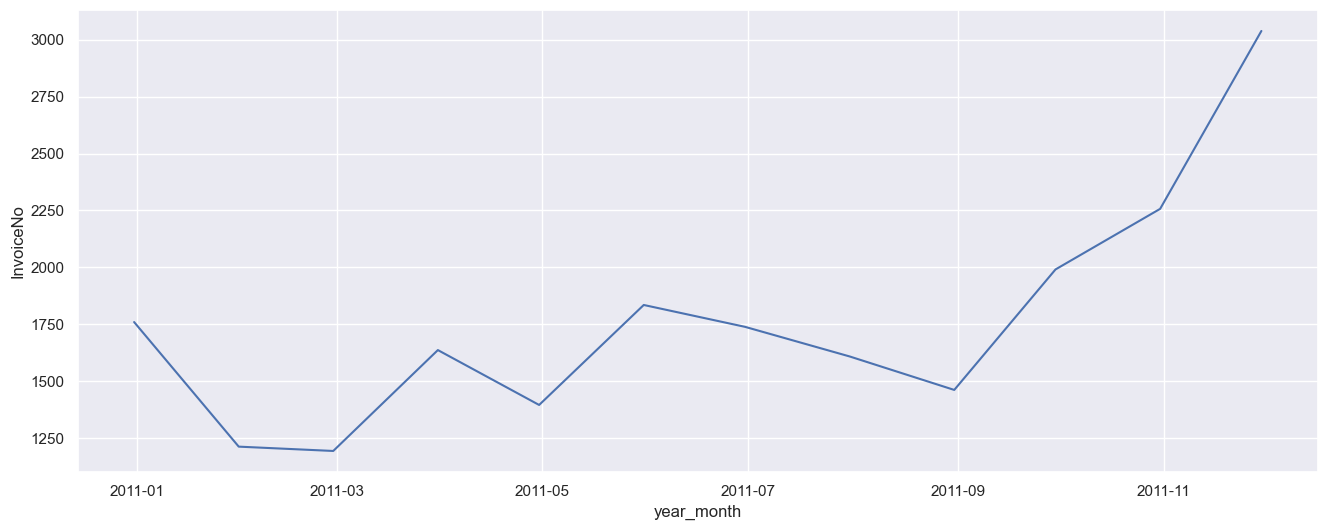

In [56]:
morders = df[['year_month','InvoiceNo']].drop_duplicates().groupby('year_month', 
        as_index=False)['InvoiceNo'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='InvoiceNo')

### Monthly Quantity

Now let's see how many items are sold per month

<Axes: xlabel='year_month', ylabel='Quantity'>

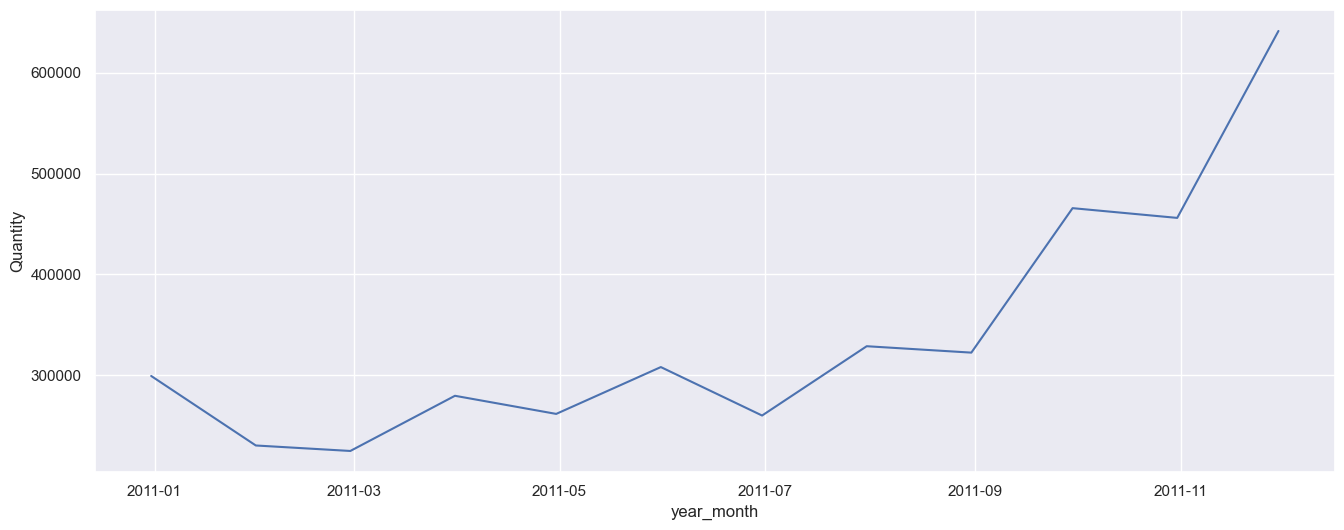

In [57]:
morders = df[['year_month','Quantity']].groupby('year_month', 
        as_index=False)['Quantity'].sum().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='Quantity')

### Monthly Active Custumers

In [58]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34


<Axes: xlabel='year_month', ylabel='CustomerID'>

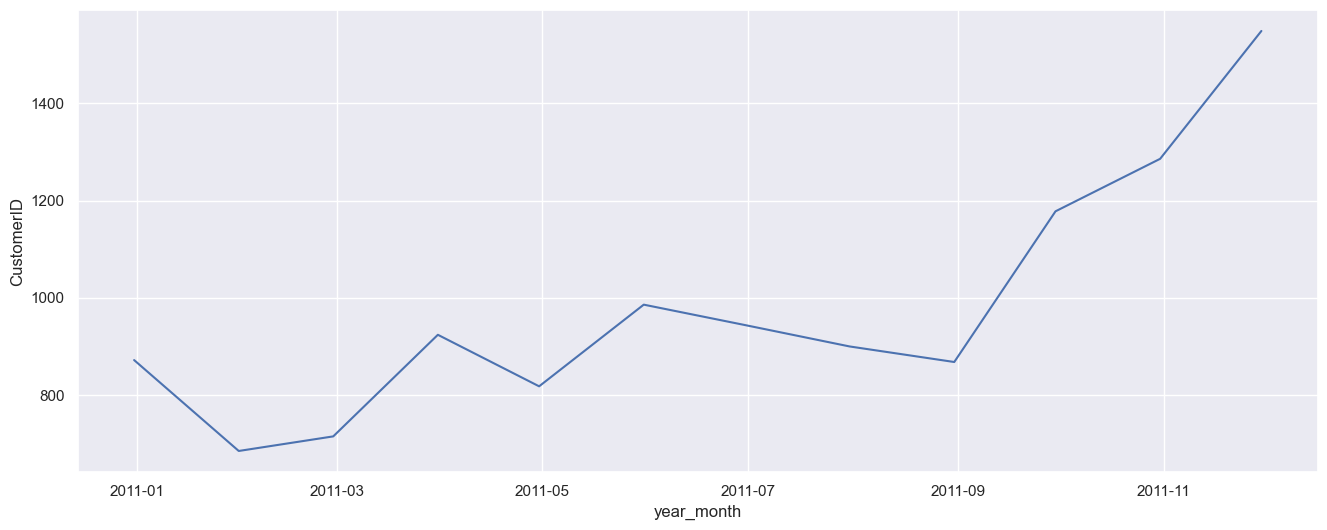

In [59]:
mcustomer = df[['year_month','CustomerID']].drop_duplicates().groupby('year_month', 
        as_index=False)['CustomerID'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=mcustomer, x='year_month', y='CustomerID')

### Monthly Customer Growth

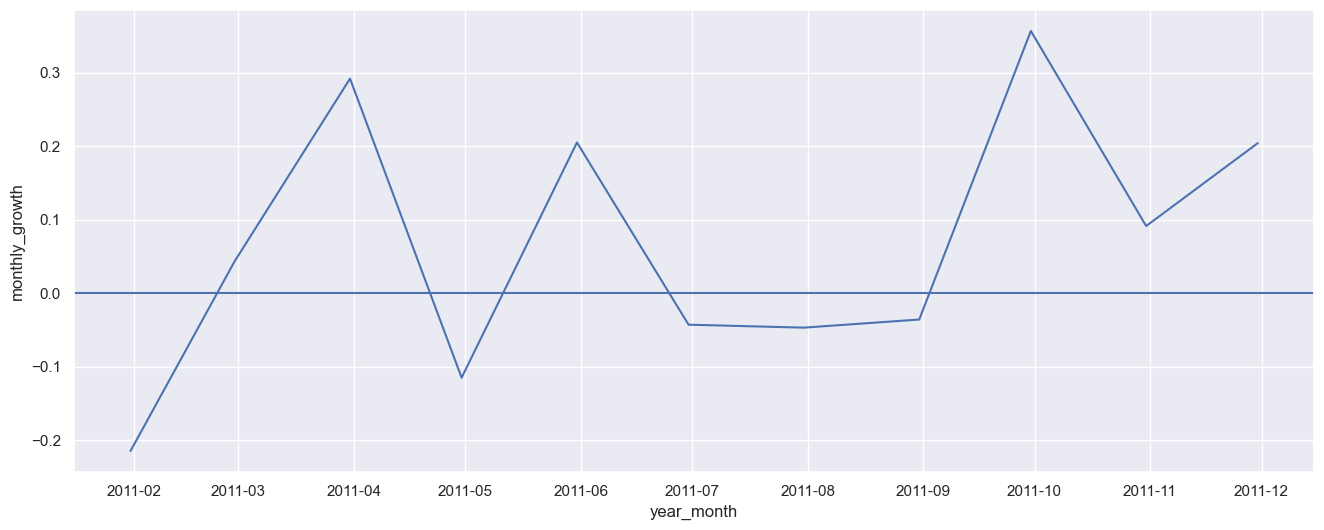

In [60]:
mcustomer = mcustomer.sort_values('year_month', ascending=True)
mcustomer['monthly_growth'] = mcustomer['CustomerID'].pct_change()
g = sns.lineplot(data=mcustomer, x='year_month', y='monthly_growth')
g.axhline(0.0)

### Monthly Avg Revenue per Order

      year_month InvoiceNo  revenue
0     2010-12-31    536365   139.12
1     2010-12-31    536366    22.20
2     2010-12-31    536367   278.73
3     2010-12-31    536368    70.05
4     2010-12-31    536369    17.85
...          ...       ...      ...
21126 2011-11-30   C579882   -14.85
21127 2011-11-30   C579883   -19.15
21128 2011-11-30   C579884   -20.53
21129 2011-11-30   C579886   -91.27
21130 2011-11-30   C579887   -20.45

[21131 rows x 3 columns]


<Axes: xlabel='year_month', ylabel='revenue'>

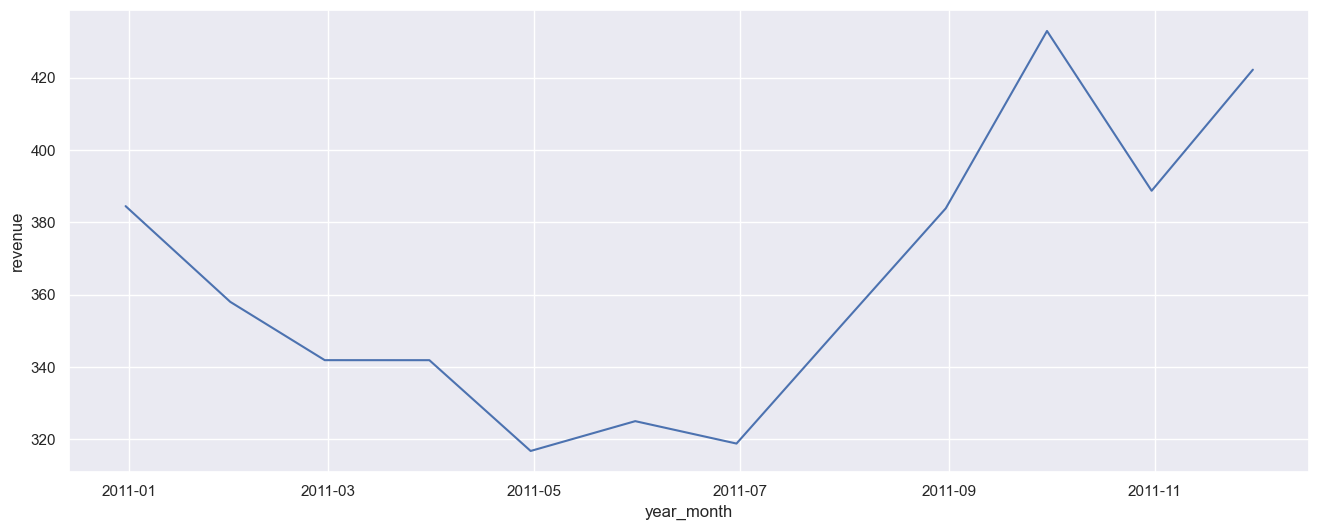

In [61]:
rorder = df[['year_month', 'InvoiceNo', 'revenue']]
# Colapsamos el revenue por Orden (InvoiceNo)
rorder = rorder.groupby(['year_month', 'InvoiceNo'], as_index=False)['revenue'].sum()
print(rorder)
# Promedio por orden
rorder = rorder.groupby('year_month', as_index=False)['revenue'].mean()
sns.lineplot(data=rorder, x='year_month', y='revenue')

In [62]:
rorder.describe()

,revenue
count,12.000000
mean,363.866436
std,38.765721
min,316.800889
25%,337.694391
50%,354.746385
75%,385.575400
max,432.957384


### Monthly Retention Rate

**Monthly Retention Rate**:= How many customers that were active last month were still active the following month.

`crosstab`:= https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

In [63]:
crevenue = df.sort_values('year_month', ascending=True).groupby(['CustomerID','year_month'], as_index=False)['revenue'].sum()
retention = pd.crosstab(crevenue['CustomerID'], crevenue['year_month']).reset_index()
retention.head()

year_month,CustomerID,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00
0,-1,1,1,1,1,1,1,1,1,1,1,1,1
1,12346,0,1,0,0,0,0,0,0,0,0,0,0
2,12747,1,1,0,1,0,1,1,0,1,0,1,1
3,12748,1,1,1,1,1,1,1,1,1,1,1,1
4,12749,0,0,0,0,0,1,0,0,1,0,0,1


In [64]:
### Loop para calcular la metrica
mes = retention.columns[2:]
retention_df = []
for m in range(len(mes)-1):
    retention_ = {}
    mes_actual = mes[m+1]
    mes_anterior = mes[m]
    retention_['year_month'] = mes_actual
    retention_['total_users'] = retention[mes_actual].sum()
    retention_['users_retained'] = retention[(retention[mes_actual]>0) & 
                                (retention[mes_anterior]>0)][mes_actual].sum()
    retention_df.append(retention_)
retention_df = pd.DataFrame(retention_df)

### Creamos la Metrica
retention_df['retention_rate'] = retention_df['users_retained']/retention_df['total_users']
retention_df.head()

,year_month,total_users,users_retained,retention_rate
0,2011-02-28,715,264,0.369231
1,2011-03-31,924,306,0.331169
2,2011-04-30,818,311,0.380196
3,2011-05-31,986,370,0.375254
4,2011-06-30,944,418,0.442797


<Axes: xlabel='year_month', ylabel='users_retained'>

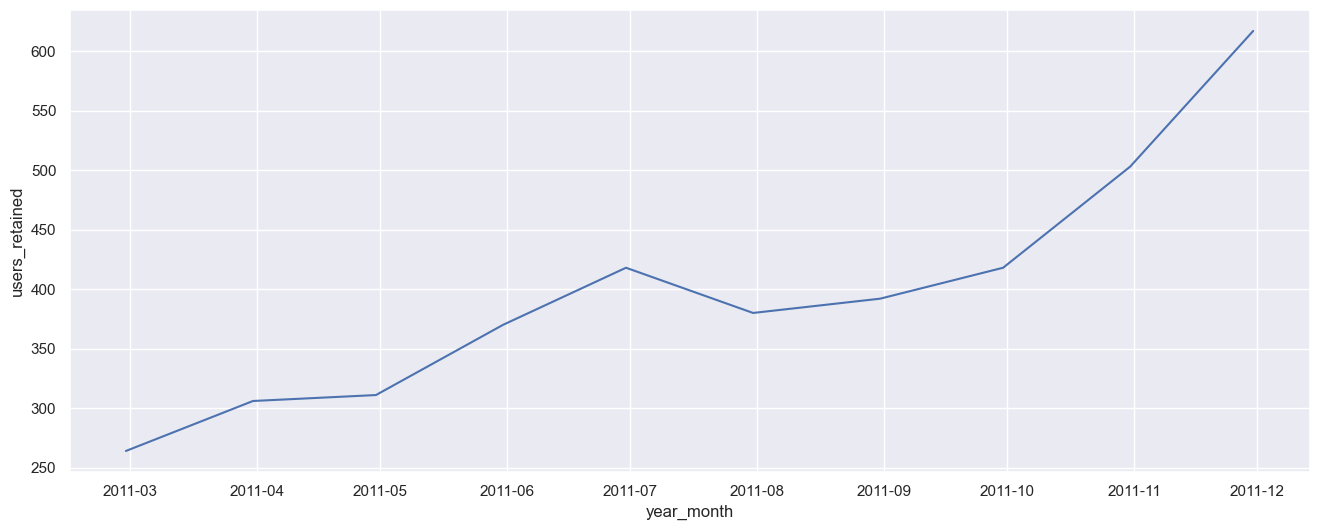

In [65]:
sns.lineplot(data=retention_df, x='year_month', y='users_retained')

<Axes: xlabel='year_month', ylabel='retention_rate'>

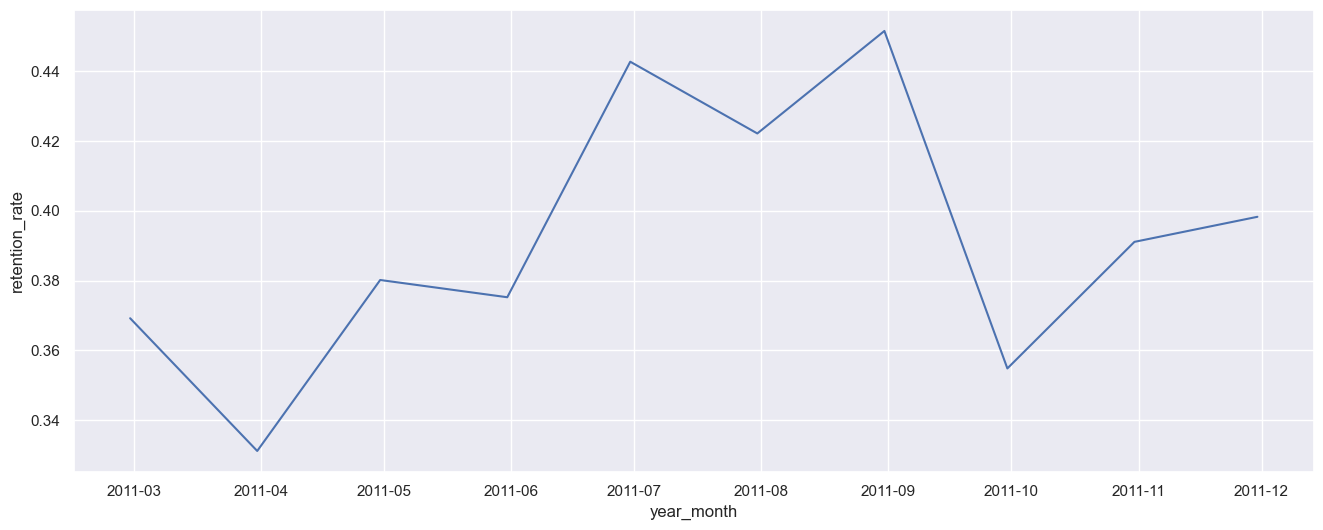

In [66]:
sns.lineplot(data=retention_df, x='year_month', y='retention_rate')

### Cohort Initial Retention Rate

**Cohort Initial Retention Rate**:= Number of users retained after their first purchase (per month).  
How many users purchase the following month, given that their first purchase was the previous month.

The following cell is based on a code of: https://stackoverflow.com/questions/20069009/pandas-get-topmost-n-records-within-each-group   



In [67]:
crevenue.head()

,CustomerID,year_month,revenue
0,-1,2010-12-31,192942.88
1,-1,2011-01-31,82327.02
2,-1,2011-02-28,59394.28
3,-1,2011-03-31,102789.52
4,-1,2011-04-30,65509.63


In [68]:
# Months in which the following purchase may occur in order to be considered retained
cohort = 1
# Date of First Purchase
primera_compra = crevenue.groupby('CustomerID', as_index=False)['year_month'].min()
primera_compra.rename(columns={'year_month':'cohort_begg'},inplace=True)

cohort_retention = crevenue.sort_values('year_month', ascending=True).groupby(
    'CustomerID').head(cohort + cohort).sort_values(['CustomerID','year_month'])
cohort_retention

,CustomerID,year_month,revenue
0,-1,2010-12-31,192942.88
1,-1,2011-01-31,82327.02
12,12346,2011-01-31,0.00
13,12747,2010-12-31,706.27
14,12747,2011-01-31,303.04
...,...,...,...
11713,18282,2011-08-31,98.76
11714,18283,2011-01-31,215.00
11715,18283,2011-02-28,102.90
11723,18287,2011-05-31,765.28


In [69]:
primera_compra

,CustomerID,cohort_begg
0,-1,2010-12-31
1,12346,2011-01-31
2,12747,2010-12-31
3,12748,2010-12-31
4,12749,2011-05-31
...,...,...
3912,18280,2011-03-31
3913,18281,2011-06-30
3914,18282,2011-08-31
3915,18283,2011-01-31


In [70]:
cohort_retention = cohort_retention[['CustomerID', 'year_month']]
# Keep only the purchase dates within the cohort sale.
cohort_retention = cohort_retention.merge(primera_compra, on='CustomerID')
cohort_retention

,CustomerID,year_month,cohort_begg
0,-1,2010-12-31,2010-12-31
1,-1,2011-01-31,2010-12-31
2,12346,2011-01-31,2011-01-31
3,12747,2010-12-31,2010-12-31
4,12747,2011-01-31,2010-12-31
...,...,...,...
6347,18282,2011-08-31,2011-08-31
6348,18283,2011-01-31,2011-01-31
6349,18283,2011-02-28,2011-01-31
6350,18287,2011-05-31,2011-05-31


In [71]:
cohort_retention['cohort_end'] = cohort_retention['cohort_begg'] + pd.DateOffset(months=cohort)
cohort_retention

,CustomerID,year_month,cohort_begg,cohort_end
0,-1,2010-12-31,2010-12-31,2011-01-31
1,-1,2011-01-31,2010-12-31,2011-01-31
2,12346,2011-01-31,2011-01-31,2011-02-28
3,12747,2010-12-31,2010-12-31,2011-01-31
4,12747,2011-01-31,2010-12-31,2011-01-31
...,...,...,...,...
6347,18282,2011-08-31,2011-08-31,2011-09-30
6348,18283,2011-01-31,2011-01-31,2011-02-28
6349,18283,2011-02-28,2011-01-31,2011-02-28
6350,18287,2011-05-31,2011-05-31,2011-06-30


In [72]:
cohort_retention = cohort_retention[cohort_retention['year_month'] <= cohort_retention['cohort_end']]
cohort_retention

,CustomerID,year_month,cohort_begg,cohort_end
0,-1,2010-12-31,2010-12-31,2011-01-31
1,-1,2011-01-31,2010-12-31,2011-01-31
2,12346,2011-01-31,2011-01-31,2011-02-28
3,12747,2010-12-31,2010-12-31,2011-01-31
4,12747,2011-01-31,2010-12-31,2011-01-31
...,...,...,...,...
6346,18281,2011-06-30,2011-06-30,2011-07-30
6347,18282,2011-08-31,2011-08-31,2011-09-30
6348,18283,2011-01-31,2011-01-31,2011-02-28
6349,18283,2011-02-28,2011-01-31,2011-02-28


In [73]:
# Detect retained
compradores = cohort_retention.groupby(['CustomerID'], as_index=False)['year_month'].count()
retenidos_cohort = compradores[compradores['year_month']>1]
# Create df with cohort window
total_retenidos = retenidos_cohort['CustomerID'].shape[0] / compradores['CustomerID'].shape[0]
total_retenidos

0.1792187898902221

If the value of `year_month` in the next cell is greater than one it means that the customer bought again in the following n-months (cohort), so it is considered retained.

In [74]:
crevenue

,CustomerID,year_month,revenue
0,-1,2010-12-31,192942.88
1,-1,2011-01-31,82327.02
2,-1,2011-02-28,59394.28
3,-1,2011-03-31,102789.52
4,-1,2011-04-30,65509.63
...,...,...,...
11720,18283,2011-09-30,134.90
11721,18283,2011-10-31,114.65
11722,18283,2011-11-30,651.56
11723,18287,2011-05-31,765.28


In [75]:
cohort_mes = []
# Date of First Purchase
primera_compra = crevenue.groupby('CustomerID', as_index=False)['year_month'].min()
primera_compra.rename(columns={'year_month':'cohort_begg'},inplace=True)
for c in range(1,12):
  cohort_retention = crevenue.sort_values('year_month', ascending=True).groupby(
    'CustomerID').head(cohort + c).sort_values(['CustomerID','year_month'])
  cohort_retention = cohort_retention[['CustomerID', 'year_month']]
  # Keep only the purchase dates within the cohort sale.
  cohort_retention = cohort_retention.merge(primera_compra, on='CustomerID')
  cohort_retention['cohort_end'] = cohort_retention['cohort_begg'] + pd.DateOffset(months=c)
  cohort_retention = cohort_retention[cohort_retention['year_month'] <= cohort_retention['cohort_end']]
  # Detect retained
  compradores = cohort_retention.groupby(['CustomerID'], as_index=False)['year_month'].count()
  retenidos_cohort = compradores[compradores['year_month']>1]
  # Create df with cohort window
  total_retenidos = retenidos_cohort['CustomerID'].shape[0] / compradores['CustomerID'].shape[0]
  df_ = pd.DataFrame({'cohort':[c], 'retencion':[total_retenidos]})
  cohort_mes.append(df_)

cohort_mes = pd.concat(cohort_mes, ignore_index=True)
cohort_mes

,cohort,retencion
0,1,0.179219
1,2,0.349502
2,3,0.421241
3,4,0.481491
4,5,0.531785
5,6,0.558591
6,7,0.578504
7,8,0.591779
8,9,0.602757
9,10,0.612714


Now let's modify the above, so that for each month the window moves, using `crosstab`.

In [76]:
# let's change the dates of month and year by a numerical identifier
crevenue['mes_int'] = crevenue['year_month'].apply(lambda x: x.year*100 + x.month)
crevenue['mes_int'].unique()

array([201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107,
       201108, 201109, 201110, 201111], dtype=int64)

In [77]:
crevenue

,CustomerID,year_month,revenue,mes_int
0,-1,2010-12-31,192942.88,201012
1,-1,2011-01-31,82327.02,201101
2,-1,2011-02-28,59394.28,201102
3,-1,2011-03-31,102789.52,201103
4,-1,2011-04-30,65509.63,201104
...,...,...,...,...
11720,18283,2011-09-30,134.90,201109
11721,18283,2011-10-31,114.65,201110
11722,18283,2011-11-30,651.56,201111
11723,18287,2011-05-31,765.28,201105


In [78]:
# Let's use crosstab to manipulate the dataframe
df_retention = pd.crosstab(crevenue['CustomerID'], crevenue['mes_int']).reset_index()
# Date of first purchase per customer
first_purchase = crevenue.groupby('CustomerID',as_index=False)['mes_int'].min()
first_purchase.rename(columns={'mes_int':'first_purchase'}, inplace=True)
# Create purchase indicator table by customer, and month(columns)
df_retention = pd.merge(df_retention,first_purchase[['CustomerID','first_purchase']],on='CustomerID')
cols = list(df_retention.columns[:-1])
cols.append('first_purchase')
df_retention.columns = cols
df_retention

,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,first_purchase
0,-1,1,1,1,1,1,1,1,1,1,1,1,1,201012
1,12346,0,1,0,0,0,0,0,0,0,0,0,0,201101
2,12747,1,1,0,1,0,1,1,0,1,0,1,1,201012
3,12748,1,1,1,1,1,1,1,1,1,1,1,1,201012
4,12749,0,0,0,0,0,1,0,0,1,0,0,1,201105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,18280,0,0,0,1,0,0,0,0,0,0,0,0,201103
3913,18281,0,0,0,0,0,0,1,0,0,0,0,0,201106
3914,18282,0,0,0,0,0,0,0,0,1,0,0,0,201108
3915,18283,0,1,1,0,1,1,1,1,0,1,1,1,201101


In [79]:
# I will enter a window for each month, similar to the metrics and sections above and previous sections.
meses = df_retention['first_purchase'].sort_values().unique()
retention_cohort = []
for m, _ in enumerate(meses):
    retention_ = {}
    selected_month = meses[m]
    mes_actual = meses[m]
    meses_anteriores = meses[:m]
    meses_siguientes = meses[m+1:]

    # Fill the previous months with nans, because nobody buys before their first purchase.
    for prev_month in meses_anteriores:
        retention_[prev_month] = np.nan
        
    usuarios_nuevos = df_retention[df_retention['first_purchase'] ==  int(mes_actual)]['first_purchase'].count()
    retention_['usuarios_nuevos'] = usuarios_nuevos
    retention_[mes_actual] = 1 
    
    query = "first_purchase == {}".format(mes_actual)
    

    for mes_siguiente in meses_siguientes:
        query_ = query + " and {} > 0".format(mes_siguiente)
        retention_[mes_siguiente] = df_retention.query(query_)[mes_siguiente].sum()/usuarios_nuevos
    
    retention_cohort.append(retention_)
    
retention_cohort = pd.DataFrame(retention_cohort)
retention_cohort.index = meses

#showing new cohort based retention table
retention_cohort

,usuarios_nuevos,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111
201012,872,1.0,0.370413,0.334862,0.378440,0.354358,0.396789,0.376147,0.349771,0.352064,0.397936,0.368119,0.493119
201101,362,NaN,1.000000,0.232044,0.279006,0.245856,0.342541,0.292818,0.262431,0.259669,0.314917,0.350829,0.361878
201102,339,NaN,NaN,1.000000,0.250737,0.191740,0.280236,0.283186,0.253687,0.259587,0.283186,0.277286,0.312684
201103,408,NaN,NaN,NaN,1.000000,0.193627,0.262255,0.215686,0.232843,0.171569,0.262255,0.237745,0.291667
201104,276,NaN,NaN,NaN,NaN,1.000000,0.224638,0.221014,0.217391,0.206522,0.231884,0.231884,0.264493
201105,252,NaN,NaN,NaN,NaN,NaN,1.000000,0.230159,0.170635,0.170635,0.214286,0.238095,0.265873
201106,207,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.212560,0.164251,0.246377,0.256039,0.323671
201107,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.203488,0.191860,0.232558,0.279070
201108,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.264286,0.228571,0.257143
201109,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.290909,0.327273


In this case we see the retention rate per month of initial purchase.

# Separation of bases for test and training

In [80]:
df_all = df.copy()
# Let's use the first 9 months to train our models.
df = df_all[df_all['year_month']< pd.to_datetime('2011-9-30')]
# Let's leave the last three months to validate our analysis.
df_test = df_all[df_all['year_month']>=pd.to_datetime('2011-9-30')]

In [81]:
df.shape

(291695, 11)

In [82]:
df_test.shape

(178416, 11)

# RMF segmentation

In this part we will segment the users based on the RMF methodology. We can also apply a variation, where instead of estimating by rank of each R-M-F variable, we use k-means on the three normalized variables.

## EDA & RMF modeling

Let's remove users with no ids from our base to simplify our analysis.

In [83]:
rmf = df.copy()
rmf = rmf[rmf['CustomerID']!=-1]

I will create a pandas where I will store the data of each client before clustering them.

In [84]:
usuarios = rmf[['CustomerID']].drop_duplicates()

In [85]:
usuarios

,CustomerID
0,17850
9,13047
46,13748
65,15100
82,15291
...,...
319722,14660
319770,13726
319809,15690
320059,17777


### Recency

#### Recency creation

Recency:= is how recent a customer's last transaction with the company was, the less recent the higher the R score in the RFM model.

In [86]:
rmf['year_month'].max()

Timestamp('2011-08-31 00:00:00')

**Date on which in theory I start the analysis**.

In [87]:
fecha_analisis = rmf['year_month'].max()

Let's calculate the Recency in days

In [88]:
rmf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34


In [89]:
recency = rmf[['CustomerID', 'year_month']].groupby('CustomerID', as_index=False).max()
recency['recency'] =  (fecha_analisis - recency['year_month']).dt.days 
recency = recency[['CustomerID', 'recency']]
recency.describe()

,CustomerID,recency
count,3027.000000,3027.000000
mean,15546.644533,77.270235
std,1583.827206,75.753324
min,12346.000000,0.000000
25%,14190.000000,0.000000
50%,15541.000000,62.000000
75%,16914.000000,123.000000
max,18287.000000,243.000000


In [90]:
recency

,CustomerID,recency
0,12346,212
1,12747,0
2,12748,0
3,12749,0
4,12820,212
...,...,...
3022,18280,153
3023,18281,62
3024,18282,0
3025,18283,31


<Axes: xlabel='recency', ylabel='Count'>

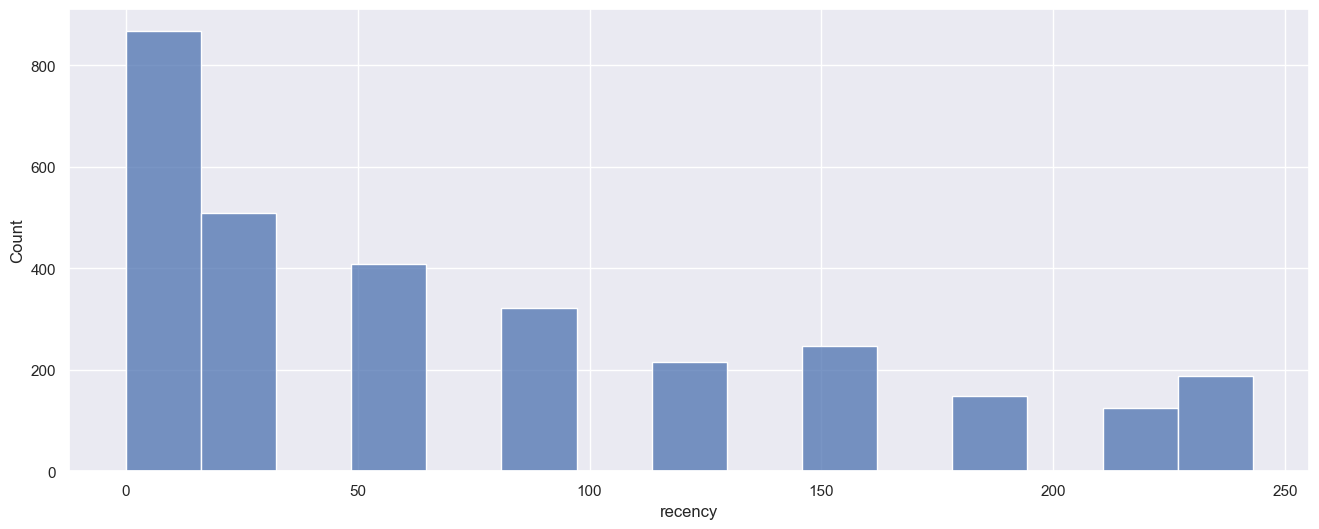

In [91]:
sns.histplot(recency['recency'])

#### Scaling

Before applying K-means it is convenient to normalize/scale the data in some way.

Documentation: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing 

<Axes: xlabel='recency_scaled', ylabel='Count'>

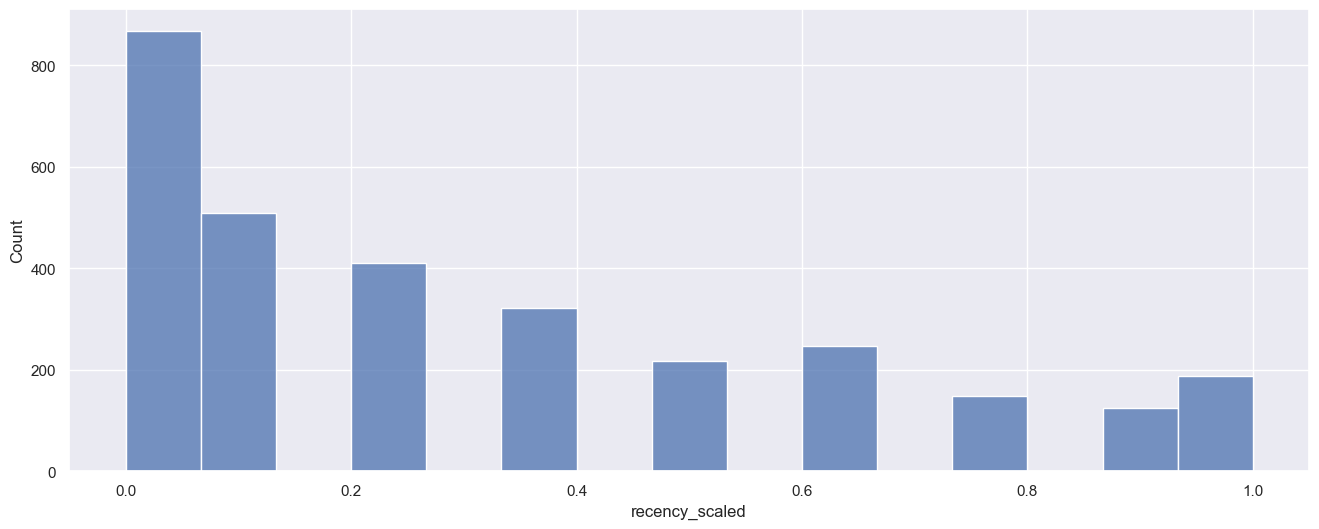

In [92]:
scaler = MinMaxScaler()
scaler.fit(recency['recency'].values.reshape(-1, 1))
recency['recency_scaled'] = scaler.transform(recency['recency'].values.reshape(-1, 1))
sns.histplot(recency['recency_scaled'])

In [93]:
recency

,CustomerID,recency,recency_scaled
0,12346,212,0.872428
1,12747,0,0.000000
2,12748,0,0.000000
3,12749,0,0.000000
4,12820,212,0.872428
...,...,...,...
3022,18280,153,0.629630
3023,18281,62,0.255144
3024,18282,0,0.000000
3025,18283,31,0.127572


<Axes: xlabel='recency_scaled', ylabel='Count'>

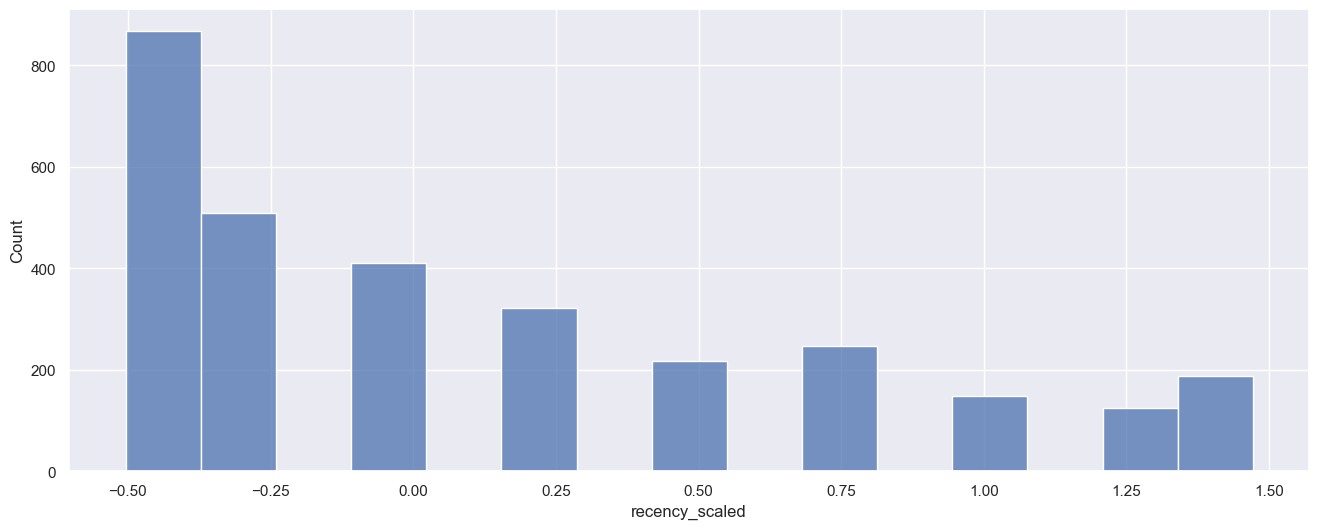

In [94]:
scaler = RobustScaler()
scaler.fit(recency['recency'].values.reshape(-1, 1))
recency['recency_scaled'] = scaler.transform(recency['recency'].values.reshape(-1, 1))
sns.histplot(recency['recency_scaled'])

In this case it seems that the data scaled with the methods do not vary much in shape, however since the distribution is very skewed I recommend using the `RobustScaler`.

In [95]:
recency

,CustomerID,recency,recency_scaled
0,12346,212,1.219512
1,12747,0,-0.504065
2,12748,0,-0.504065
3,12749,0,-0.504065
4,12820,212,1.219512
...,...,...,...
3022,18280,153,0.739837
3023,18281,62,0.000000
3024,18282,0,-0.504065
3025,18283,31,-0.252033


In [96]:
recency['r'] = recency['recency_scaled']

In [97]:
recency

,CustomerID,recency,recency_scaled,r
0,12346,212,1.219512,1.219512
1,12747,0,-0.504065,-0.504065
2,12748,0,-0.504065,-0.504065
3,12749,0,-0.504065,-0.504065
4,12820,212,1.219512,1.219512
...,...,...,...,...
3022,18280,153,0.739837,0.739837
3023,18281,62,0.000000,0.000000
3024,18282,0,-0.504065,-0.504065
3025,18283,31,-0.252033,-0.252033


In [98]:
usuarios

,CustomerID
0,17850
9,13047
46,13748
65,15100
82,15291
...,...
319722,14660
319770,13726
319809,15690
320059,17777


In [99]:
usuarios = usuarios.merge(recency[['CustomerID', 'r']], on = 'CustomerID')
usuarios.head()

,CustomerID,r
0,17850,0.991870
1,13047,-0.504065
2,13748,0.495935
3,15100,1.219512
4,15291,0.000000


### Monetary

In this case the Monetary part corresponds to the monthly revenue, so we will calculate it using the monthly values.   
**However**, if we were to do it on a weekly basis, the result could change radically.    
For example, two users who have the same monthly revenue may have radical purchase averages, so the suggested strategy could change substantially. It may be that the one who buys often prefers free shipping coupons or vice versa, it all depends on our particular problem.

#### Creation of Monetary (revenue)

Let's create the df to cluster according to monetary values (revenue per month)

In [100]:
rmf

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34
...,...,...,...,...,...,...,...,...,...,...,...
320700,C565077,23196,VINTAGE LEAF MAGNETIC NOTEPAD,-3,8/31/2011 17:31,1.45,17451,United Kingdom,2011-08-31 17:31:00,2011-08-31,-4.35
320701,C565077,22189,CREAM HEART CARD HOLDER,-1,8/31/2011 17:31,3.95,17451,United Kingdom,2011-08-31 17:31:00,2011-08-31,-3.95
320702,C565077,23239,SET OF 4 KNICK KNACK TINS POPPIES,-1,8/31/2011 17:31,4.15,17451,United Kingdom,2011-08-31 17:31:00,2011-08-31,-4.15
320703,C565077,23197,SKETCHBOOK MAGNETIC SHOPPING LIST,-12,8/31/2011 17:31,1.45,17451,United Kingdom,2011-08-31 17:31:00,2011-08-31,-17.40


In [101]:
monetary =  rmf[['CustomerID', 'year_month', 'revenue']].groupby(['CustomerID', 'year_month'], as_index=False).sum()
monetary = monetary.groupby('CustomerID', as_index=False).mean()
monetary.rename(columns={'revenue':'monetary'}, inplace=True)
monetary.describe()

,CustomerID,monetary
count,3027.000000,3027.000000
mean,15546.644533,385.405033
std,1583.827206,585.216372
min,12346.000000,-4287.630000
25%,14190.000000,165.000000
50%,15541.000000,285.006667
75%,16914.000000,438.120000
max,18287.000000,15914.802500


#### Scaling

<Axes: xlabel='monetary', ylabel='Density'>

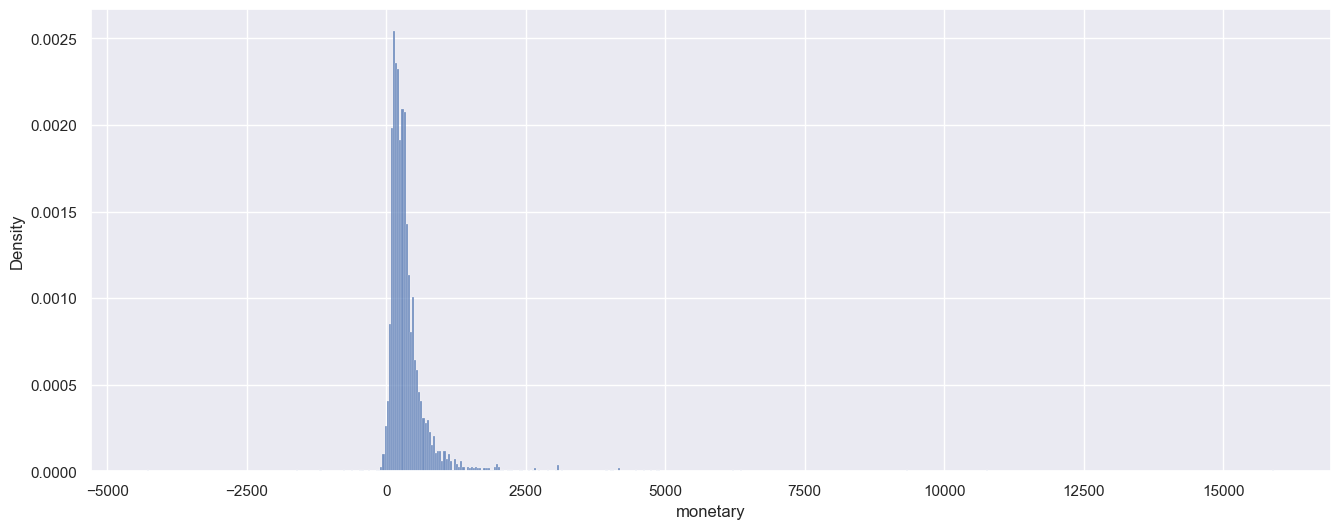

In [102]:
sns.histplot(monetary['monetary'], stat='density')

<Axes: xlabel='m', ylabel='Density'>

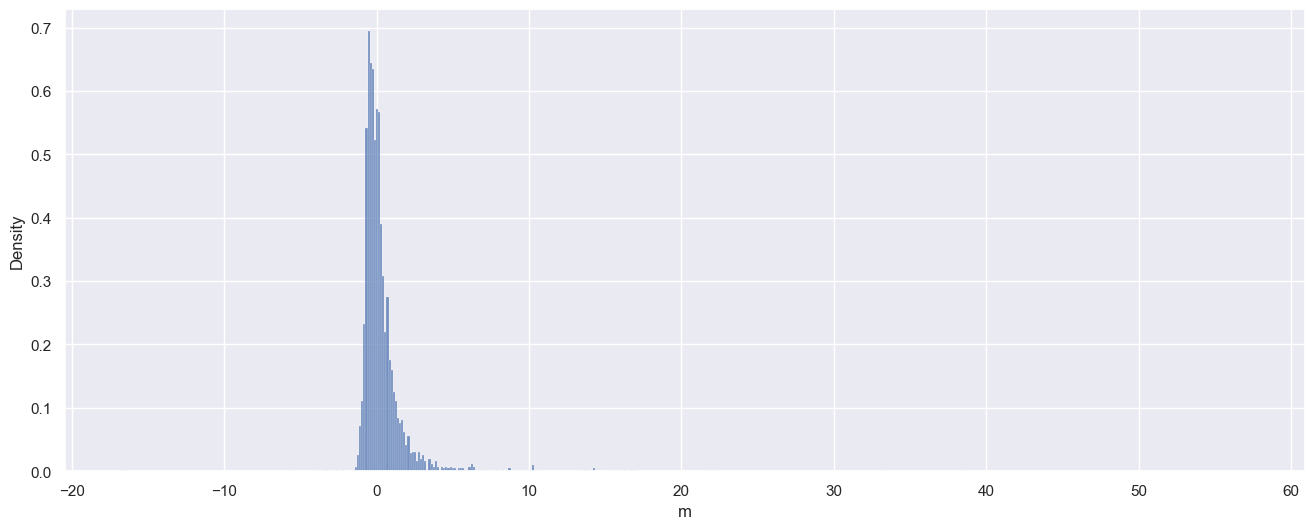

In [103]:
scaler = RobustScaler()
scaler.fit(monetary['monetary'].values.reshape(-1, 1))
monetary['m'] = scaler.transform(monetary['monetary'].values.reshape(-1, 1))
sns.histplot(monetary['m'], stat='density')

We can observe that there are many outliers in our distribution, it would be advisable to take care of that. We could ignore them and leave them in our analysis, or we could use an outlier detection algorithm and remove them so that they do not affect the core of our analysis. This style of decision making depends very much on the project we are doing.

In [104]:
monetary['m'].describe()

count    3027.000000
mean        0.367598
std         2.142708
min       -16.742226
25%        -0.439392
50%         0.000000
75%         0.560608
max        57.226845
Name: m, dtype: float64

In [105]:
usuarios = usuarios.merge(monetary[['CustomerID', 'm']], on = 'CustomerID')
usuarios.head()

,CustomerID,r,m
0,17850,0.991870,8.638358
1,13047,-0.504065,0.127859
2,13748,0.495935,0.019839
3,15100,1.219512,0.119154
4,15291,0.000000,1.325020


### Frequency

#### Creation of Frequency

We will create the df with the potential months of each customer. We want to see how many months he has purchased since his first purchase.

In [106]:
meses_potenciales = rmf.groupby('CustomerID', as_index=False)['year_month'].min()
meses_potenciales['meses_potenciales'] = (fecha_analisis - meses_potenciales['year_month']).dt.days 
# Let's convert days to months
meses_potenciales['meses_potenciales'] = meses_potenciales['meses_potenciales'].apply(lambda x: int(x/30) + 1)
del meses_potenciales['year_month']
meses_potenciales.head()

,CustomerID,meses_potenciales
0,12346,8
1,12747,9
2,12748,9
3,12749,4
4,12820,8


In [107]:
frequency = rmf[['CustomerID', 'year_month']]
# Remember that we are evaluating aggregated purchases on a monthly basis.
frequency = frequency[['CustomerID', 'year_month']].drop_duplicates()
frequency = frequency.groupby('CustomerID', as_index=False)['year_month'].count()
frequency.rename(columns={'year_month':'n_compras'}, inplace=True)
frequency = frequency.merge(meses_potenciales, on='CustomerID')
frequency['frequency'] = frequency['n_compras']/frequency['meses_potenciales']
frequency.describe()

,CustomerID,n_compras,meses_potenciales,frequency
count,3027.000000,3027.000000,3027.000000,3027.000000
mean,15546.644533,2.544764,6.293029,0.434045
std,1583.827206,1.993271,2.490238,0.269539
min,12346.000000,1.000000,1.000000,0.111111
25%,14190.000000,1.000000,4.000000,0.222222
50%,15541.000000,2.000000,7.000000,0.333333
75%,16914.000000,3.000000,9.000000,0.571429
max,18287.000000,9.000000,9.000000,1.000000


<Axes: xlabel='frequency', ylabel='Density'>

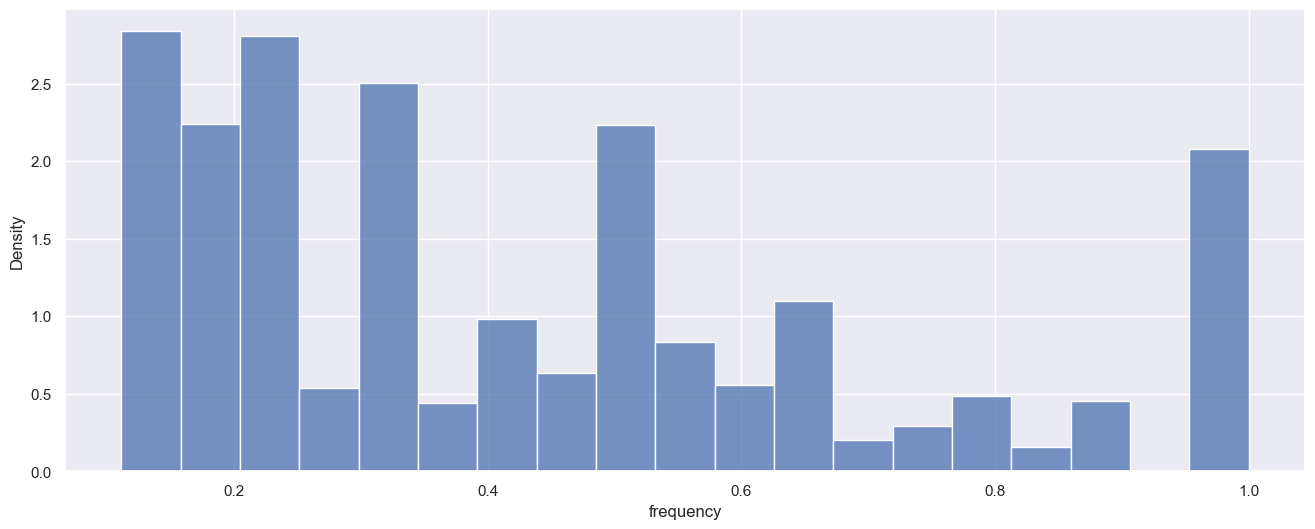

In [108]:
sns.histplot(frequency['frequency'], stat='density')

### Scaling 

In this case, since the values are already between 0 and 1, scaling is not necessary.

In [109]:
frequency['f'] = frequency['frequency']
usuarios = usuarios.merge(frequency[['CustomerID', 'f']], on = 'CustomerID')
usuarios.head()

,CustomerID,r,m,f
0,17850,0.991870,8.638358,0.222222
1,13047,-0.504065,0.127859,0.888889
2,13748,0.495935,0.019839,0.222222
3,15100,1.219512,0.119154,0.222222
4,15291,0.000000,1.325020,0.555556


(-1.5, 2.0)

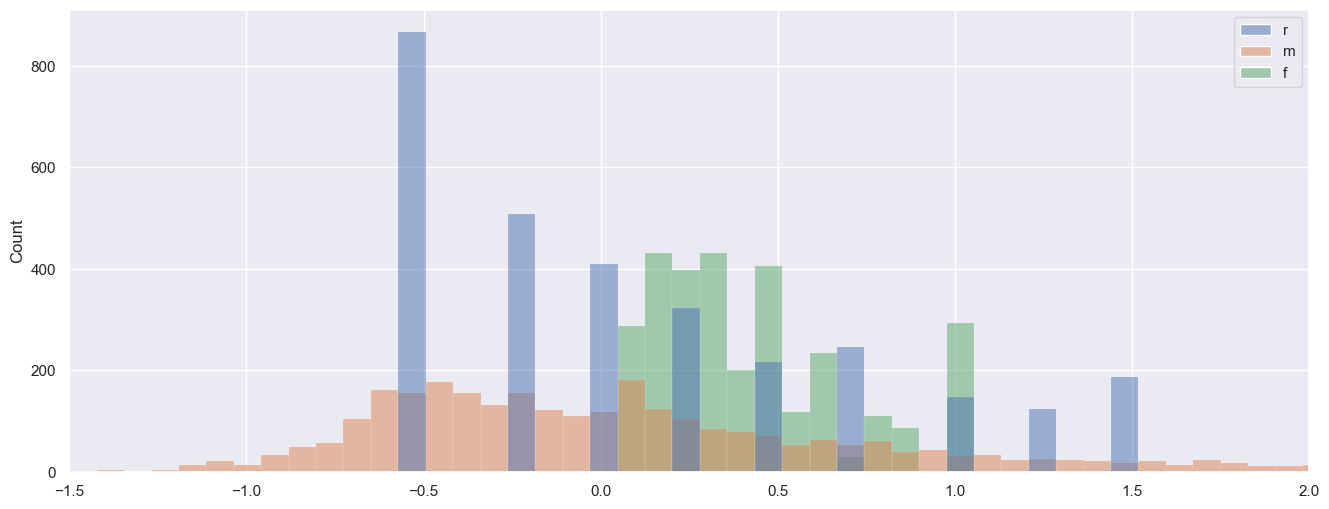

In [110]:
sns.histplot(usuarios[['r','m','f']])
plt.xlim([-1.5,2])

### Outliers Control

Now that we have created our variables let's use an outlier control algorithm known as **Isolation forest**

Documentacion: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html   
Example: https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [111]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=365).fit(usuarios[['r', 'm', 'f']])
usuarios['outlier'] = clf.predict(usuarios[['r', 'm', 'f']])
# To return string to the outliers
usuarios['outlier'] = usuarios['outlier'].apply(lambda x: 'outlier' if x==-1 else 'normal')

In [112]:
usuarios.head()

,CustomerID,r,m,f,outlier
0,17850,0.991870,8.638358,0.222222,outlier
1,13047,-0.504065,0.127859,0.888889,outlier
2,13748,0.495935,0.019839,0.222222,normal
3,15100,1.219512,0.119154,0.222222,outlier
4,15291,0.000000,1.325020,0.555556,outlier


In [113]:
usuarios.groupby('outlier')[['r', 'm', 'f']].describe()

r                                                              \
          count      mean       std       min       25%       50%       75%   
outlier                                                                       
normal   2172.0 -0.012921  0.446739 -0.504065 -0.504065  0.000000  0.243902   
outlier   855.0  0.472353  0.817000 -0.504065 -0.504065  0.495935  1.219512   

                        m            ...                            f  \
              max   count      mean  ...       75%        max   count   
outlier                              ...                                
normal   0.991870  2172.0  0.006488  ...  0.325845   2.111648  2172.0   
outlier  1.471545   855.0  1.284943  ...  1.931066  57.226845   855.0   

                                                                    
             mean       std       min    25%    50%       75%  max  
outlier                                                             
normal   0.439464  0.238215  0.142857  0.250  0.375  0.555556  1.0  
outlier  0.420278  0.336013  0.111111  0.125  0.250  0.777778  1.0  

[2 rows x 24 columns]

Note how the standard deviation of our variables is much larger in the outliers, in addition to having more extreme values. With the exception of frequency, this may be due to the fact that by construction frequency is not a very volatile variable, since it is given by the months of analysis.

### EDA RMF

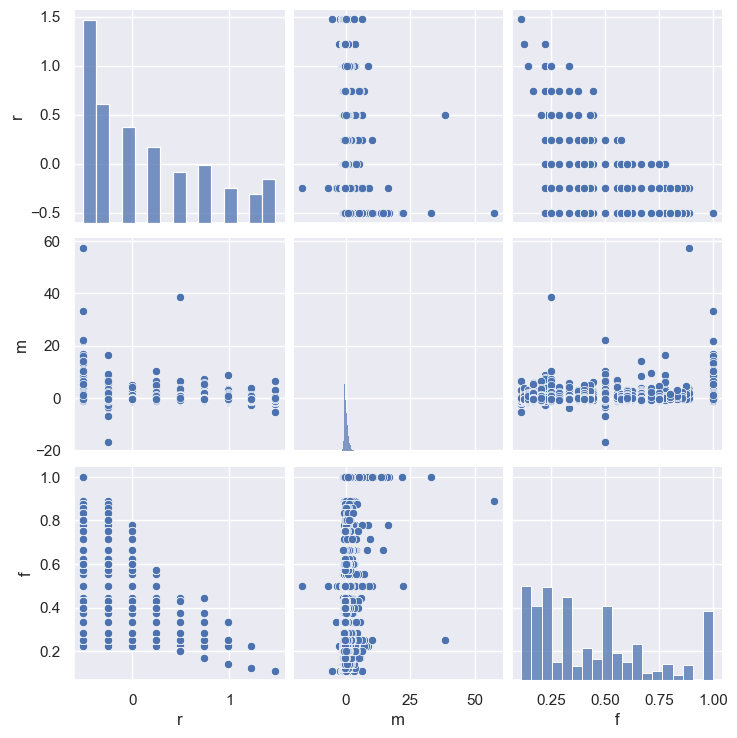

In [114]:
sns.pairplot(usuarios[['r','m', 'f']])

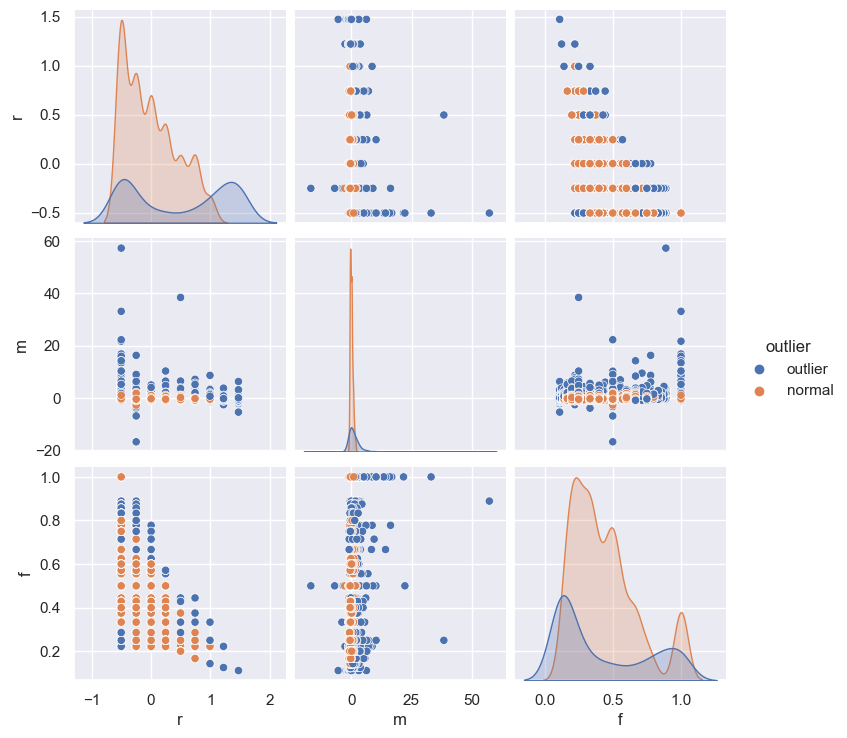

In [115]:
sns.pairplot(usuarios[['r','m', 'f','outlier']], hue='outlier')

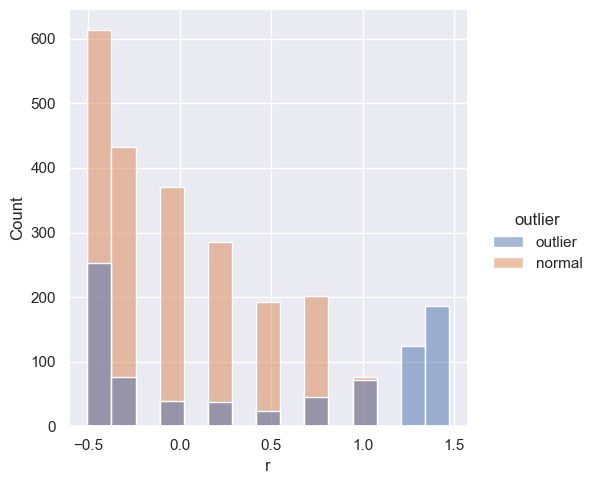

In [116]:
sns.displot(data=usuarios, x='r', hue='outlier')

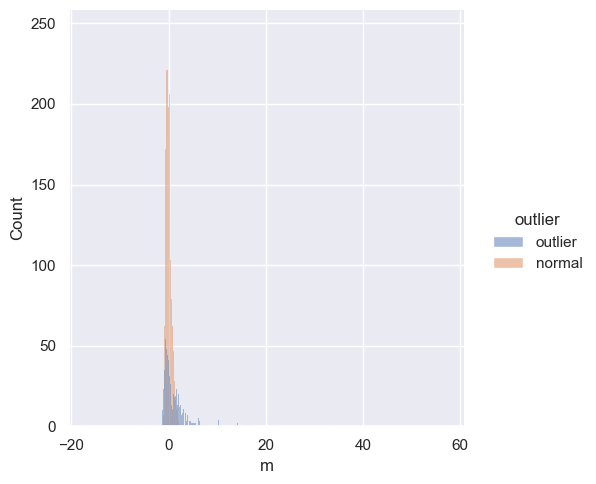

In [117]:
sns.displot(data=usuarios, x='m', hue='outlier')

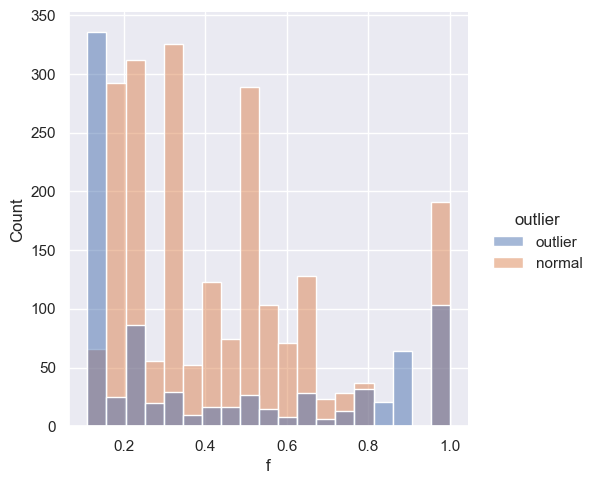

In [118]:
sns.displot(data=usuarios, x='f', hue='outlier')

In general it seems that the only one that can cause problems when clustering is the `m` variable or the revenue, because there are very important outliers.  
  
IsolationForest takes into account all three variables. If the objective of the campaign is to focus on common users, then it is convenient to remove the outliers. If, on the other hand, the goal is to retain large customers, then no.  

Also, we can control it at the time of making the clusters.

# Clusters RMF

There are now several ways to do the RMF clustering.  

+ **Classical**: One way is to cluster by variable (separately), sort/rank these clusters by assigning a score and thus create an aggregate score.  
+ **Alternative**: Apply k-means on the 3 variables, normalized/scaled appropriately, directly.

The advantage of the classical way is that the interpretation is a bit simpler compared to the multivariate alternative in which each cluster has to be interpreted and given an intuition.  
  
In addition, the second alternative requires a proper scaling, since k-means is very susceptible to the unit/dimension/size of the varaibles.  
  
However, if done correctly, the multivariate form in general will have better results, since it takes into account all variables simultaneously, and does not require assigning arbitrary points.

In this case, the alternative multivariate technique will be used.

In [154]:
def elbow_method(df, columns=[], max_clust=10):
  sse={}
  df_ = df[columns].copy()
  for k in range(1, max_clust+1):
      kmeans = KMeans(n_clusters=k, max_iter=10000, n_init='auto').fit(df_)
      df_["cluster"] = kmeans.labels_
      sse[k] = kmeans.inertia_ 
  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of Clusters")
  plt.show()

In [120]:
## RMF clasico
# Function to sort cluster according to their average
def order_cluster_mean(df, cluster_col, val_col,ascending=True):
    df_new = df.groupby(cluster_col, as_index=False)[val_col].mean()
    df_new = df_new.sort_values(by=val_col,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_col,'index']], on=cluster_col)
    df_final = df_final.drop([cluster_col],axis=1)
    df_final = df_final.rename(columns={"index":cluster_col})
    return df_final

In [150]:
## RMF classic
def univariate_cluster_k(df, col, n_clusters=1):
  df_ = df[col].copy()
  kmeans = KMeans(n_clusters=n_clusters)
  kmeans.fit(df_)
  clust_col = 'cluster_' + str(n_clusters)
  df_[clust_col] = kmeans.predict(df_)
  df_ = order_cluster_mean(df=df_, cluster_col=clust_col, val_col=col,ascending=True)
  sns.displot(data= df_, x=col,hue=clust_col)

### Rescaling

In [153]:
usuarios.describe()

,CustomerID,r,m,f,sr,sm,sf
count,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000
mean,15546.644533,0.124148,0.367598,0.434045,0.317985,0.231311,0.363300
std,1583.827206,0.615881,2.142708,0.269539,0.311742,0.028968,0.303231
min,12346.000000,-0.504065,-16.742226,0.111111,0.000000,0.000000,0.000000
25%,14190.000000,-0.504065,-0.439392,0.222222,0.000000,0.220401,0.125000
50%,15541.000000,0.000000,0.000000,0.333333,0.255144,0.226341,0.250000
75%,16914.000000,0.495935,0.560608,0.571429,0.506173,0.233920,0.517857
max,18287.000000,1.471545,57.226845,1.000000,1.000000,1.000000,1.000000


Let us observe how each varaible has different dimensions, so it is necessary to scale them again so that they all live in the same interval. Just look at the pairplot we generated earlier. 
+ Why didn't we do that from the beginning? The answer is that we were doing an EDA and what we wanted to do was to understand the distribution, our analysis allowed us to detect understand the behavior of the customers, infer if it was necessary to detect outliers, and know better the distribution.
+ The previous analysis is more focused on the classical RMF, so it is only important to scale the variable in a univariate way.
+ Now it is time to scale the variables so that they live in the same interval, it will be enough to apply the min-max scaler to our prescaled variables.

In [123]:
scaler = MinMaxScaler()
scaler.fit(usuarios[['r','m','f']])
usuarios[['sr','sm','sf']] = scaler.transform(usuarios[['r','m','f']])
usuarios.describe()

,CustomerID,r,m,f,sr,sm,sf
count,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000
mean,15546.644533,0.124148,0.367598,0.434045,0.317985,0.231311,0.363300
std,1583.827206,0.615881,2.142708,0.269539,0.311742,0.028968,0.303231
min,12346.000000,-0.504065,-16.742226,0.111111,0.000000,0.000000,0.000000
25%,14190.000000,-0.504065,-0.439392,0.222222,0.000000,0.220401,0.125000
50%,15541.000000,0.000000,0.000000,0.333333,0.255144,0.226341,0.250000
75%,16914.000000,0.495935,0.560608,0.571429,0.506173,0.233920,0.517857
max,18287.000000,1.471545,57.226845,1.000000,1.000000,1.000000,1.000000


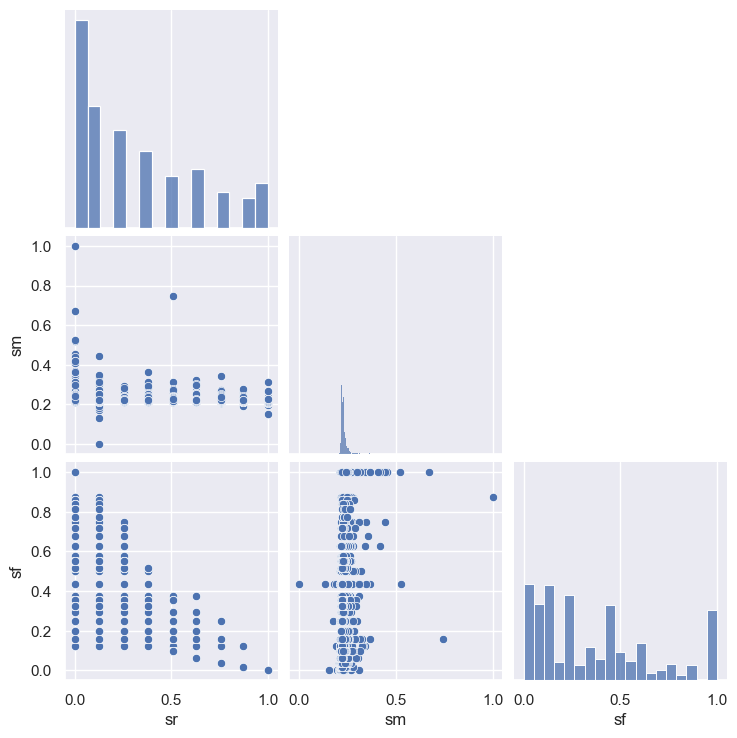

In [124]:
sns.pairplot(usuarios[['sr','sm','sf']], corner=True)

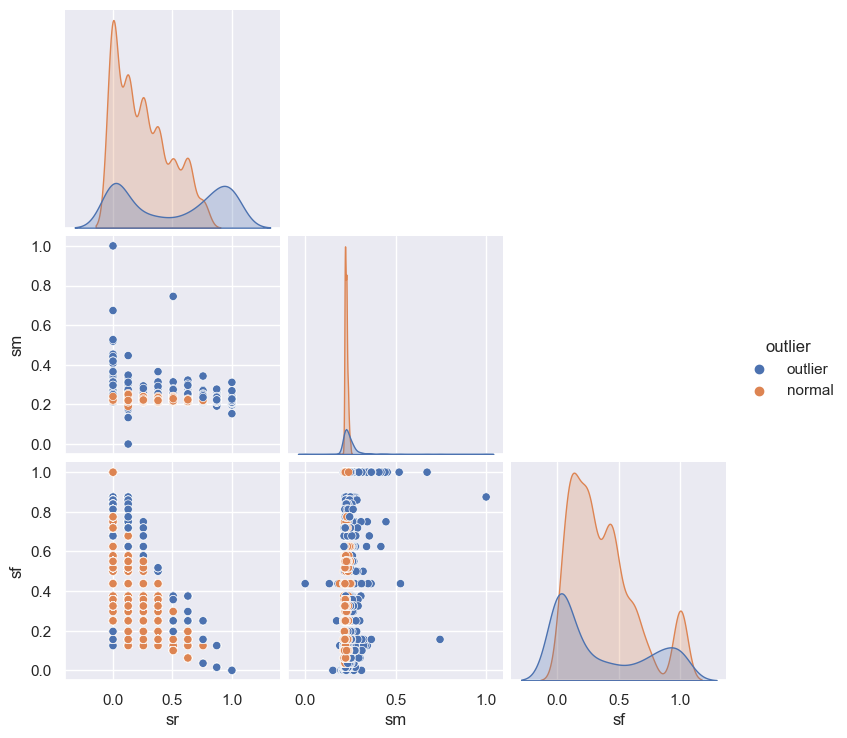

In [125]:
sns.pairplot(usuarios[['sr','sm','sf', 'outlier']], hue='outlier', corner=True)

+ The variables scaled in a `RobustScaler` way allow us to place atypical data in proper clusters because they keep their distance.  
+ While the scaled varaibles with `MinMax` allow us to accommodate customers closer to what would be a ranking, because even if the difference between two observations is very large in a certain variable, it is lessened by the scaling. In addition to giving the **same weight to all variables**.  
  
    
**Example**.  
Note the following two individuals.
`RobustScaler`: [40, 2, .1] & [2, 2, .1].  
`MinMax`: [.5, .3, .1] & [.1, .3, .1]   
In the first case of `RobustScaler` the Euclidean distance between the two is abysmal, so the first one ends up in a separate cluster, while in the second case `MinMax` the distance is much smaller and they may end up in the same cluster.  
Intuitively what is happening with the `MinMax` is that it is giving the same weight to all the variables, so even though they differ a lot in one variable in the others they are very similar.  
    
**In general  
It is preferable to use the `MinMax` because it is difficult to calculate what weight we want to give to each variable, and it is better to give them the same weight. Then we can deal with the particularities separately. In the example above we prefer to use `MinMax` and then treat separately that individual who has very outliers through outlier detection. It may be a very important customer, so it requires a special treatment.




## Clustering

### With outliers

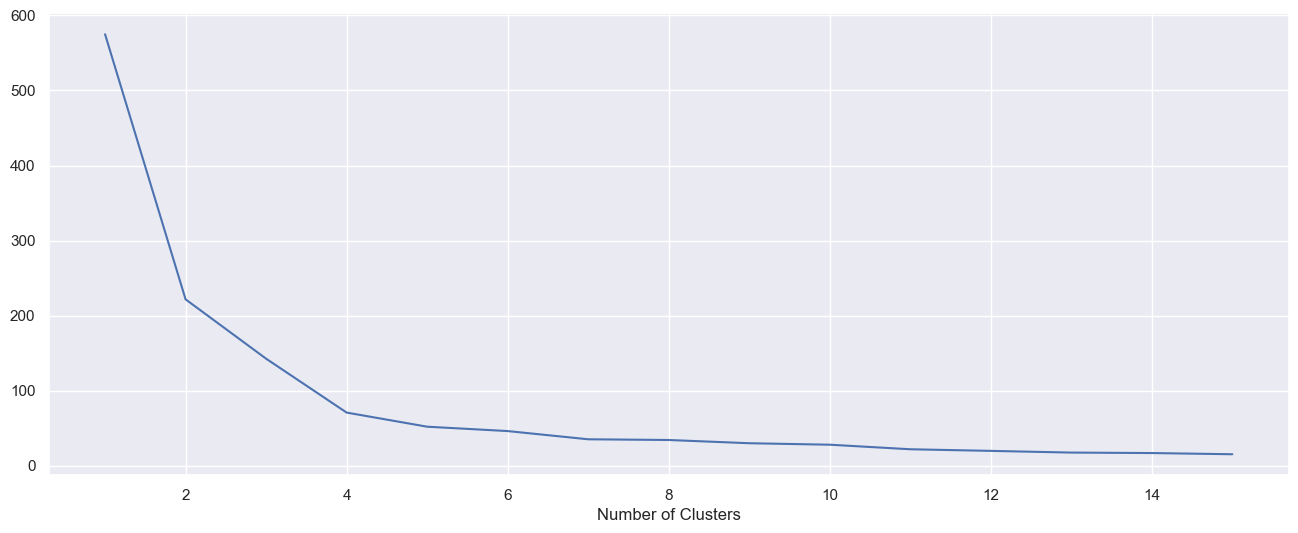

In [155]:
elbow_method(df=usuarios, columns=['sr','sm','sf'], max_clust=15)

It seems that the optimum is between 6 and 8, although 4 is also acceptable. Be sure to discuss with the team what is the optimal number of clusters given the objectives and constraints.

#### 6 clusters

In [164]:
kmeans = KMeans(n_clusters=6, random_state=345, n_init=10)
kmeans.fit(usuarios[['sr','sm','sf']])
usuarios['cluster_6'] = kmeans.predict(usuarios[['sr','sm','sf']])
usuarios['cluster_6'] =   usuarios['cluster_6'].apply(lambda x: 'c'+str(x))
usuarios[['cluster_6','sr','sm','sf']].groupby('cluster_6').describe()

sr                                                              \
           count      mean       std       min       25%       50%       75%   
cluster_6                                                                      
c0         452.0  0.889262  0.103029  0.757202  0.757202  0.872428  1.000000   
c1         422.0  0.047764  0.072199  0.000000  0.000000  0.000000  0.127572   
c2         378.0  0.003712  0.021472  0.000000  0.000000  0.000000  0.000000   
c3         654.0  0.309265  0.078494  0.127572  0.255144  0.316872  0.378601   
c4         657.0  0.106213  0.087354  0.000000  0.000000  0.127572  0.127572   
c5         464.0  0.575413  0.065163  0.506173  0.506173  0.629630  0.629630   

                        sm            ...                         sf  \
                max  count      mean  ...       75%       max  count   
cluster_6                             ...                              
c0         1.000000  452.0  0.225240  ...  0.228617  0.343124  452.0   
c1         0.255144  422.0  0.234386  ...  0.237473  0.446449  422.0   
c2         0.127572  378.0  0.246728  ...  0.248432  1.000000  378.0   
c3         0.506173  654.0  0.228224  ...  0.231424  0.365482  654.0   
c4         0.255144  657.0  0.229970  ...  0.233895  0.526943  657.0   
c5         0.757202  464.0  0.228115  ...  0.229423  0.745236  464.0   

                                                                               
               mean       std     min       25%       50%       75%       max  
cluster_6                                                                      
c0         0.026993  0.039456  0.0000  0.000000  0.015625  0.035714  0.156250  
c1         0.633901  0.080736  0.5000  0.578125  0.625000  0.718750  0.812500  
c2         0.968874  0.059297  0.8125  1.000000  1.000000  1.000000  1.000000  
c3         0.225951  0.078588  0.1250  0.156250  0.250000  0.250000  0.517857  
c4         0.383873  0.092442  0.1250  0.325000  0.437500  0.437500  0.550000  
c5         0.115930  0.068551  0.0625  0.062500  0.100000  0.125000  0.375000  

[6 rows x 24 columns]

In [165]:
usuarios

,CustomerID,r,m,f,outlier,sr,sm,sf,cluster_6,cluster_8
0,17850,0.991870,8.638358,0.222222,outlier,0.757202,0.343124,0.125,c0,c2
1,13047,-0.504065,0.127859,0.888889,outlier,0.000000,0.228069,0.875,c2,c3
2,13748,0.495935,0.019839,0.222222,normal,0.506173,0.226609,0.125,c5,c1
3,15100,1.219512,0.119154,0.222222,outlier,0.872428,0.227952,0.125,c0,c7
4,15291,0.000000,1.325020,0.555556,outlier,0.255144,0.244254,0.500,c4,c5
...,...,...,...,...,...,...,...,...,...,...
3022,14660,-0.504065,-0.571385,1.000000,normal,0.000000,0.218616,1.000,c2,c3
3023,13726,-0.504065,0.028095,1.000000,normal,0.000000,0.226721,1.000,c2,c3
3024,15690,-0.504065,-0.637107,1.000000,normal,0.000000,0.217728,1.000,c2,c3
3025,17777,-0.504065,-0.330648,1.000000,normal,0.000000,0.221871,1.000,c2,c3


In [166]:
usuarios[['cluster_6','sr','sm','sf']].groupby('cluster_6').mean()

,sr,sm,sf
cluster_6,,,
c0,0.889262,0.225240,0.026993
c1,0.047764,0.234386,0.633901
c2,0.003712,0.246728,0.968874
c3,0.309265,0.228224,0.225951
c4,0.106213,0.229970,0.383873
c5,0.575413,0.228115,0.115930


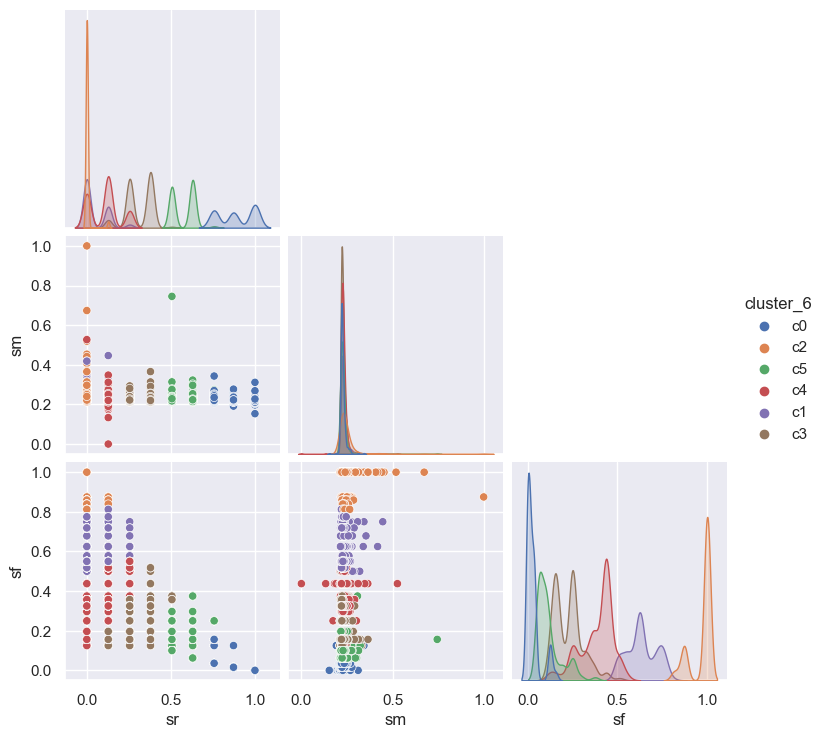

In [167]:
sns.pairplot(usuarios[['sr','sm','sf', 'cluster_6']], hue='cluster_6', corner=True)

#### 8 clusters

In [163]:
kmeans = KMeans(n_clusters=8, random_state=345, n_init=10)
kmeans.fit(usuarios[['sr','sm','sf']])
usuarios['cluster_8'] = kmeans.predict(usuarios[['sr','sm','sf']])
usuarios['cluster_8'] =   usuarios['cluster_8'].apply(lambda x: 'c'+str(x))
usuarios[['cluster_8','sr','sm','sf']].groupby('cluster_8').describe()

sr                                                              \
           count      mean       std       min       25%       50%       75%   
cluster_8                                                                      
c0         355.0  0.041326  0.063514  0.000000  0.000000  0.000000  0.127572   
c1         511.0  0.435473  0.066282  0.378601  0.378601  0.378601  0.506173   
c2         388.0  0.678291  0.062047  0.629630  0.629630  0.629630  0.757202   
c3         378.0  0.003712  0.021472  0.000000  0.000000  0.000000  0.000000   
c4         255.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
c5         436.0  0.184902  0.079921  0.127572  0.127572  0.127572  0.255144   
c6         393.0  0.216191  0.058829  0.127572  0.127572  0.255144  0.255144   
c7         311.0  0.949135  0.062564  0.872428  0.872428  1.000000  1.000000   

                        sm            ...                         sf  \
                max  count      mean  ...       75%       max  count   
cluster_8                             ...                              
c0         0.255144  355.0  0.234388  ...  0.237220  0.446449  355.0   
c1         0.629630  511.0  0.229471  ...  0.232149  0.745236  511.0   
c2         0.757202  388.0  0.226766  ...  0.229216  0.343124  388.0   
c3         0.127572  378.0  0.246728  ...  0.248432  1.000000  378.0   
c4         0.000000  255.0  0.233949  ...  0.236488  0.526943  255.0   
c5         0.378601  436.0  0.228282  ...  0.233114  0.347851  436.0   
c6         0.255144  393.0  0.227641  ...  0.230709  0.331075  393.0   
c7         1.000000  311.0  0.224468  ...  0.227746  0.311350  311.0   

                                                                       \
               mean       std       min       25%       50%       75%   
cluster_8                                                               
c0         0.652861  0.071651  0.517857  0.625000  0.625000  0.718750   
c1         0.173593  0.072718  0.100000  0.100000  0.156250  0.250000   
c2         0.078528  0.055184  0.035714  0.035714  0.062500  0.062500   
c3         0.968874  0.059297  0.812500  1.000000  1.000000  1.000000   
c4         0.352279  0.108991  0.125000  0.250000  0.357143  0.437500   
c5         0.447193  0.055423  0.357143  0.437500  0.437500  0.437500   
c6         0.237060  0.053720  0.125000  0.250000  0.250000  0.250000   
c7         0.014670  0.032749  0.000000  0.000000  0.000000  0.015625   

                     
                max  
cluster_8            
c0         0.812500  
c1         0.375000  
c2         0.296875  
c3         1.000000  
c4         0.500000  
c5         0.625000  
c6         0.325000  
c7         0.125000  

[8 rows x 24 columns]

In [168]:
usuarios[['cluster_8','sr','sm','sf']].groupby('cluster_8').mean()

,sr,sm,sf
cluster_8,,,
c0,0.041326,0.234388,0.652861
c1,0.435473,0.229471,0.173593
c2,0.678291,0.226766,0.078528
c3,0.003712,0.246728,0.968874
c4,0.000000,0.233949,0.352279
c5,0.184902,0.228282,0.447193
c6,0.216191,0.227641,0.237060
c7,0.949135,0.224468,0.014670


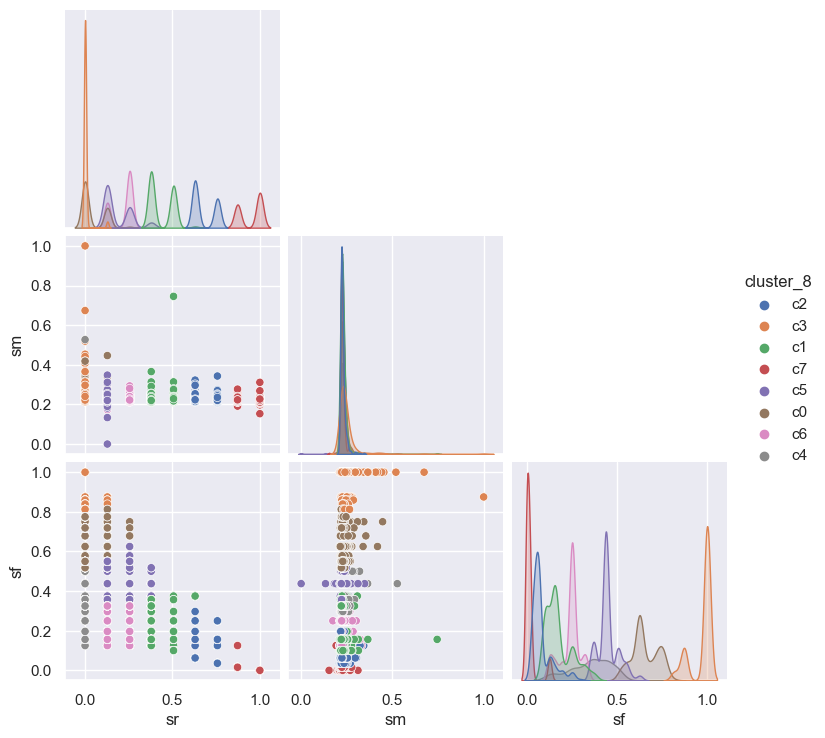

In [169]:
sns.pairplot(usuarios[['sr','sm','sf', 'cluster_8']], hue='cluster_8', corner=True)

In [170]:
usuarios[['cluster_6','sr','sm','sf']].groupby('cluster_6').mean()

,sr,sm,sf
cluster_6,,,
c0,0.889262,0.225240,0.026993
c1,0.047764,0.234386,0.633901
c2,0.003712,0.246728,0.968874
c3,0.309265,0.228224,0.225951
c4,0.106213,0.229970,0.383873
c5,0.575413,0.228115,0.115930


c0 -> They are current users who have made transactions very close to the maximum date, and with little or no frequency of transactions made by these users.

c1 -> They are very old users who have not made transactions close to the maximum date, their frequency is high on the platform and their monetary value is among the highest.

c2 -> They are non-current users, their monetary value is the highest of all groups and their frequency is the highest, they have recently made purchases.

c3 -> They are a group of users who have made transactions somewhat far away from the maximum date, their monetary value is very close to c0, c4 and c5 and they have very low frequency with conversions.

c4 -> their actuality is very low, they have a low frequency of conversions.

c5 -> They are users with transactions somewhat close to the maximum date, their actuality is a little above the average and they have little frequency or have made very few transactions.

### Evaluate metrics by cluster

Evaluate the various metrics proposed for each of the clusters (in the first 9 months (the ones we use for clustering)):  
+ Monthly Revenue
+ Monthly Revenue Growth
+ Monthly Active Costumers
+ Monthly Consumer Growth
+ Cohort Retention Rate

In [171]:
df_cluster = df[df['CustomerID'].isin(usuarios['CustomerID'])]
df_cluster = df.merge(usuarios[['CustomerID','cluster_6']], on='CustomerID')
df_cluster.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year_month,revenue,cluster_6
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,15.30,c0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010-12-31,20.34,c0


### Monthly Revenue

<Axes: xlabel='year_month', ylabel='revenue'>

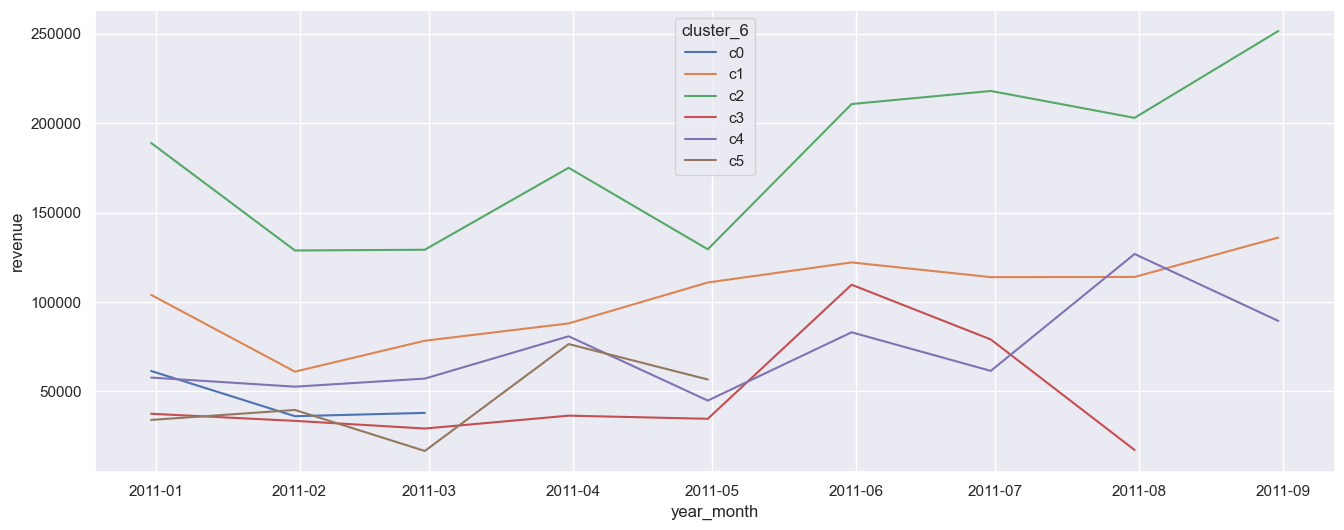

In [172]:
mrevenue = df_cluster.groupby(['year_month','cluster_6'],
                                  as_index=False)['revenue'].sum().sort_values('year_month', ascending=True)

sns.lineplot(data=mrevenue, x='year_month', y='revenue', hue='cluster_6')

### Monthly Revenue Growth
Cuánto han crecido las ventas mes a mes

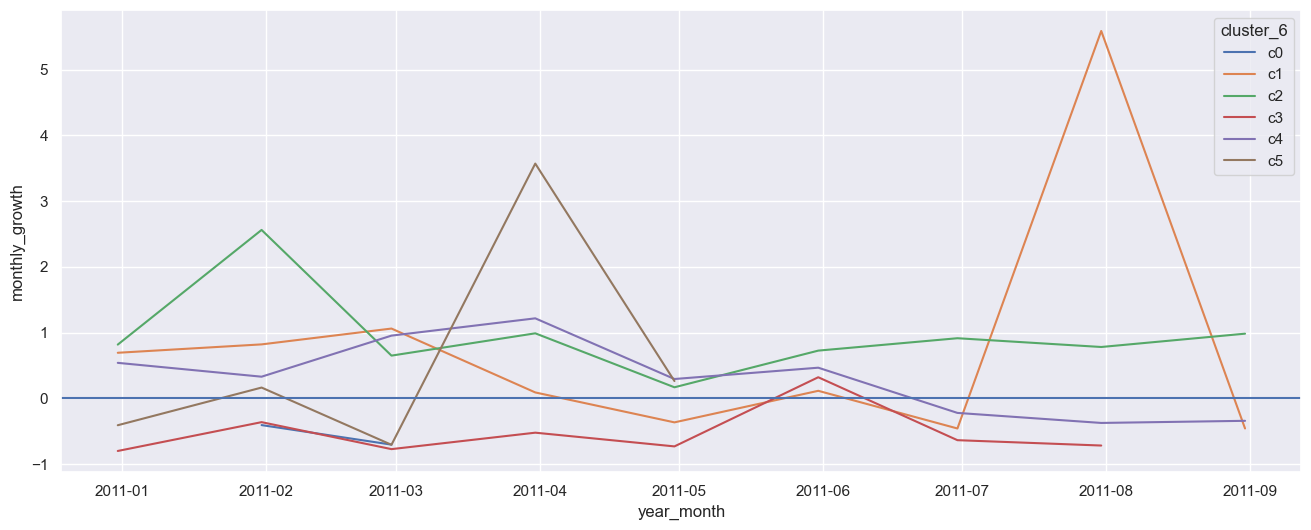

In [173]:
mrevenue['monthly_growth'] = mrevenue['revenue'].pct_change()
g = sns.lineplot(data=mrevenue, x='year_month', y='monthly_growth', hue='cluster_6')
g.axhline(0.0)

### Monthly Orders
Cuántas compras/ordenes se hacen por mes

<Axes: xlabel='year_month', ylabel='InvoiceNo'>

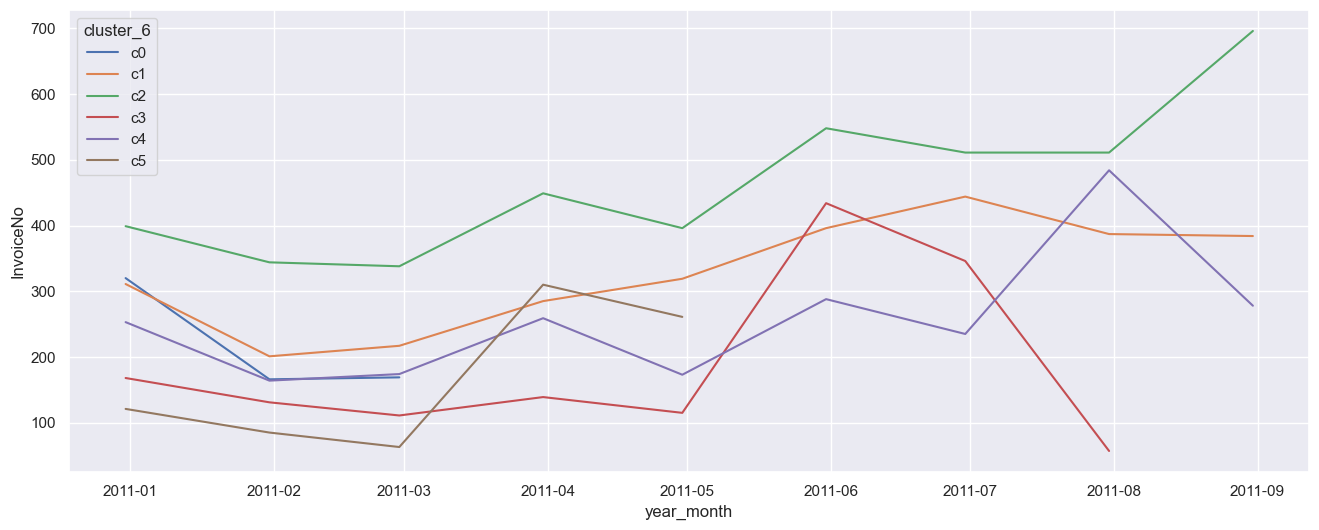

In [174]:
morders = df_cluster[['year_month','InvoiceNo', 'cluster_6']].drop_duplicates().groupby(['year_month',
        'cluster_6'], as_index=False)['InvoiceNo'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='InvoiceNo', hue='cluster_6')

## Monthly Quantity
Cuántos articulos se venden por mes

<Axes: xlabel='year_month', ylabel='Quantity'>

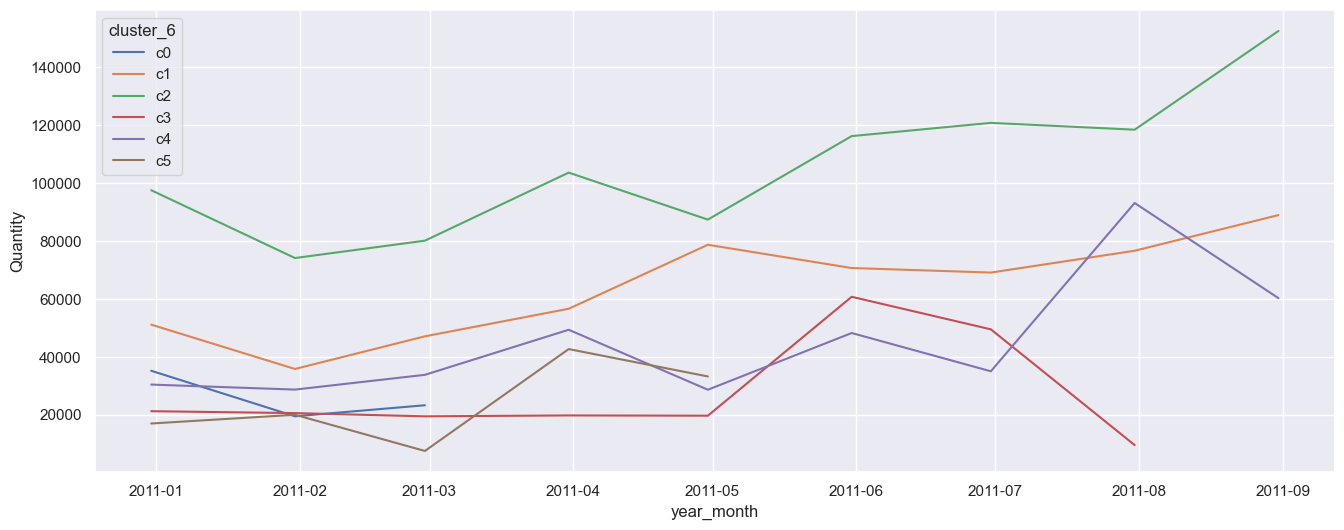

In [175]:
morders = df_cluster[['year_month','Quantity','cluster_6']].groupby(['year_month', 'cluster_6'],
        as_index=False)['Quantity'].sum().sort_values('year_month', ascending=True)
sns.lineplot(data=morders, x='year_month', y='Quantity', hue='cluster_6')

### Monthly Active Custumers

<Axes: xlabel='year_month', ylabel='CustomerID'>

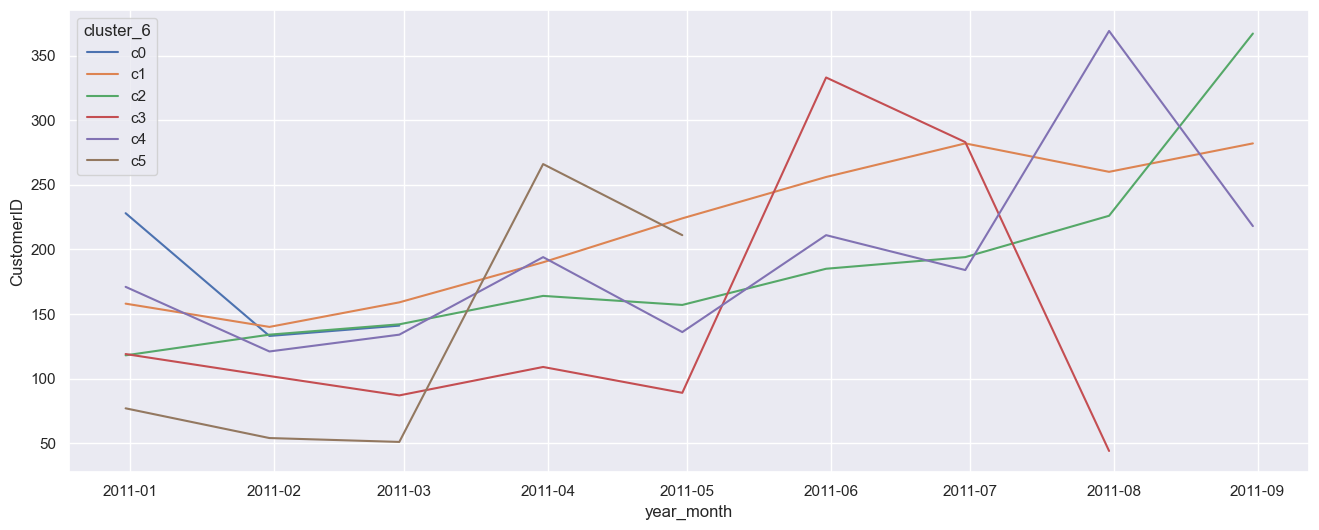

In [176]:
mcustomer = df_cluster[['year_month','CustomerID', 'cluster_6']].drop_duplicates().groupby(['year_month', 
        'cluster_6'], as_index=False)['CustomerID'].count().sort_values('year_month', ascending=True)
sns.lineplot(data=mcustomer, x='year_month', y='CustomerID', hue='cluster_6')

### Monthly Customer Growth

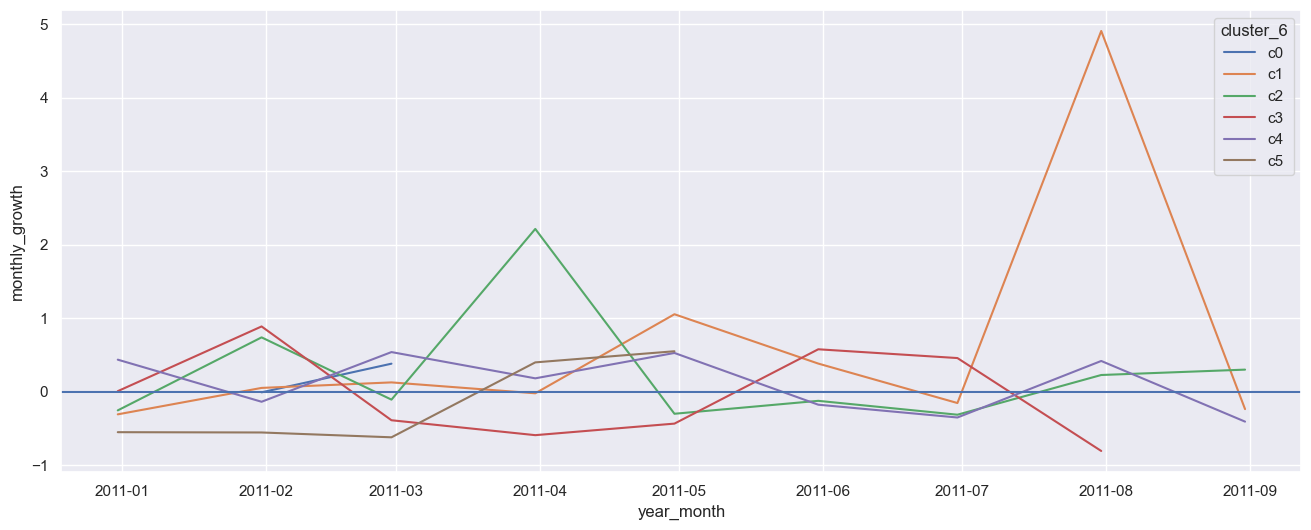

In [177]:
mcustomer = mcustomer.sort_values('year_month', ascending=True)
mcustomer['monthly_growth'] = mcustomer['CustomerID'].pct_change()
g = sns.lineplot(data=mcustomer, x='year_month', y='monthly_growth', hue='cluster_6')
g.axhline(0.0)

### Monthly Avg Revenue per Order

      year_month InvoiceNo cluster_6  revenue
0     2010-12-31    536365        c0   139.12
1     2010-12-31    536366        c0    22.20
2     2010-12-31    536367        c2   278.73
3     2010-12-31    536368        c2    70.05
4     2010-12-31    536369        c2    17.85
...          ...       ...       ...      ...
12435 2011-08-31   C565026        c2  -151.20
12436 2011-08-31   C565044        c1 -3969.93
12437 2011-08-31   C565075        c2   -74.69
12438 2011-08-31   C565077        c2   -29.85
12439 2011-08-31   C565078        c2   -57.60

[12440 rows x 4 columns]


<Axes: xlabel='year_month', ylabel='revenue'>

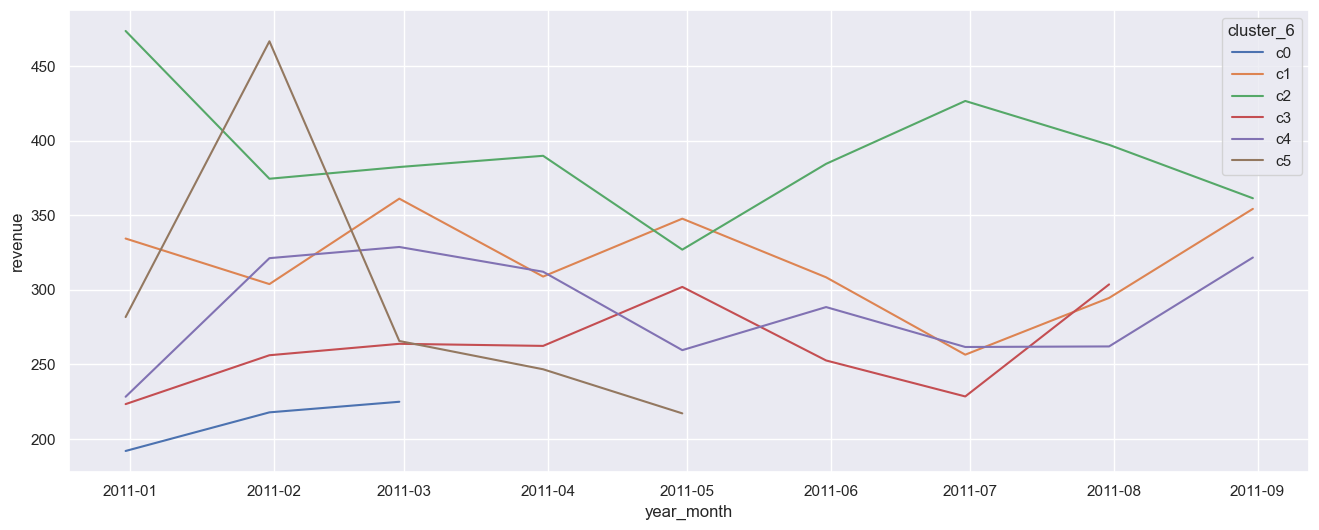

In [178]:
rorder = df_cluster[['year_month', 'InvoiceNo', 'revenue', 'cluster_6']]
# Colapsar el revenue por Orden (InvoiceNo)
rorder = rorder.groupby(['year_month', 'InvoiceNo', 'cluster_6'], as_index=False)['revenue'].sum()
print(rorder)
# Promedio por orden
rorder = rorder.groupby(['year_month', 'cluster_6'], as_index=False)['revenue'].mean()
sns.lineplot(data=rorder, x='year_month', y='revenue', hue='cluster_6')

### Monthly Retention Rate
How many customers who were active last month were still active the following month.

In [179]:
crevenue = df_cluster.sort_values('year_month', ascending=True).groupby(['CustomerID',
                        'year_month','cluster_6'], as_index=False)['revenue'].sum()
retention = pd.crosstab(crevenue['CustomerID'], crevenue['year_month']).reset_index()
retention.head()

year_month,CustomerID,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00
0,12346,0,1,0,0,0,0,0,0,0
1,12747,1,1,0,1,0,1,1,0,1
2,12748,1,1,1,1,1,1,1,1,1
3,12749,0,0,0,0,0,1,0,0,1
4,12820,0,1,0,0,0,0,0,0,0


In [180]:
### Loop to calculate the metric
mes = retention.columns[2:]
retention_df = []
for m in range(len(mes)-1):
    retention_ = {}
    mes_actual = mes[m+1]
    mes_anterior = mes[m]
    retention_['year_month'] = mes_actual
    retention_['total_users'] = retention[mes_actual].sum()
    retention_['users_retained'] = retention[(retention[mes_actual]>0) & 
                                (retention[mes_anterior]>0)][mes_actual].sum()
    retention_df.append(retention_)
retention_df = pd.DataFrame(retention_df)

### Create the Metrica
retention_df['retention_rate'] = retention_df['users_retained']/retention_df['total_users']
retention_df.head()

,year_month,total_users,users_retained,retention_rate
0,2011-02-28,714,263,0.368347
1,2011-03-31,923,305,0.330444
2,2011-04-30,817,310,0.379437
3,2011-05-31,985,369,0.374619
4,2011-06-30,943,417,0.442206


In [181]:
retention_df

,year_month,total_users,users_retained,retention_rate
0,2011-02-28,714,263,0.368347
1,2011-03-31,923,305,0.330444
2,2011-04-30,817,310,0.379437
3,2011-05-31,985,369,0.374619
4,2011-06-30,943,417,0.442206
5,2011-07-31,899,379,0.421580
6,2011-08-31,867,391,0.450980


<Axes: xlabel='year_month', ylabel='users_retained'>

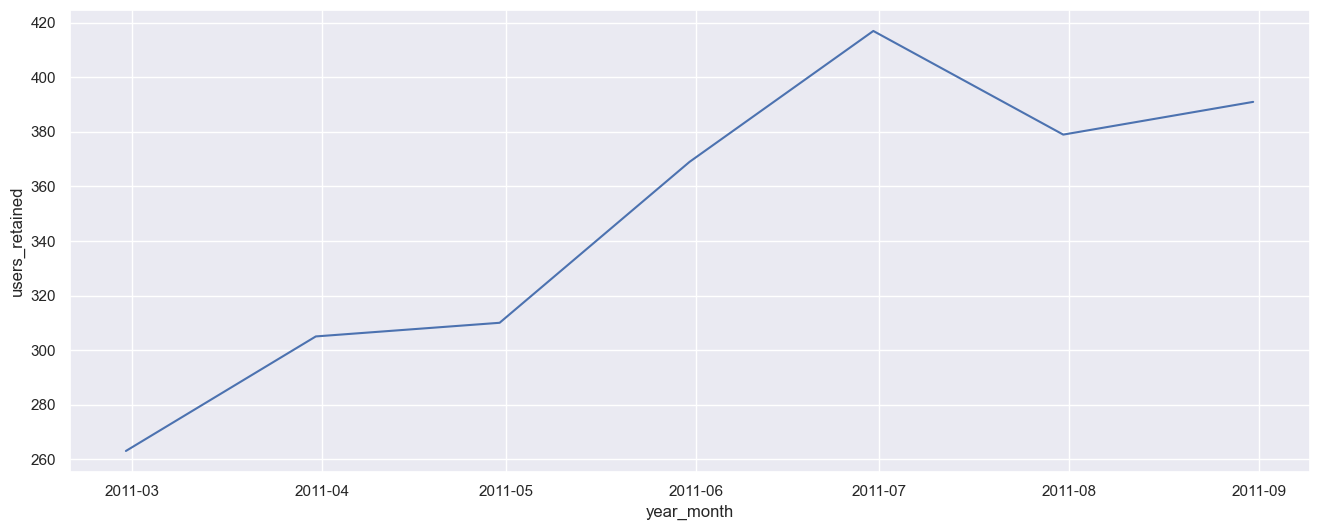

In [182]:
sns.lineplot(data=retention_df, x='year_month', y='users_retained')

<Axes: xlabel='year_month', ylabel='retention_rate'>

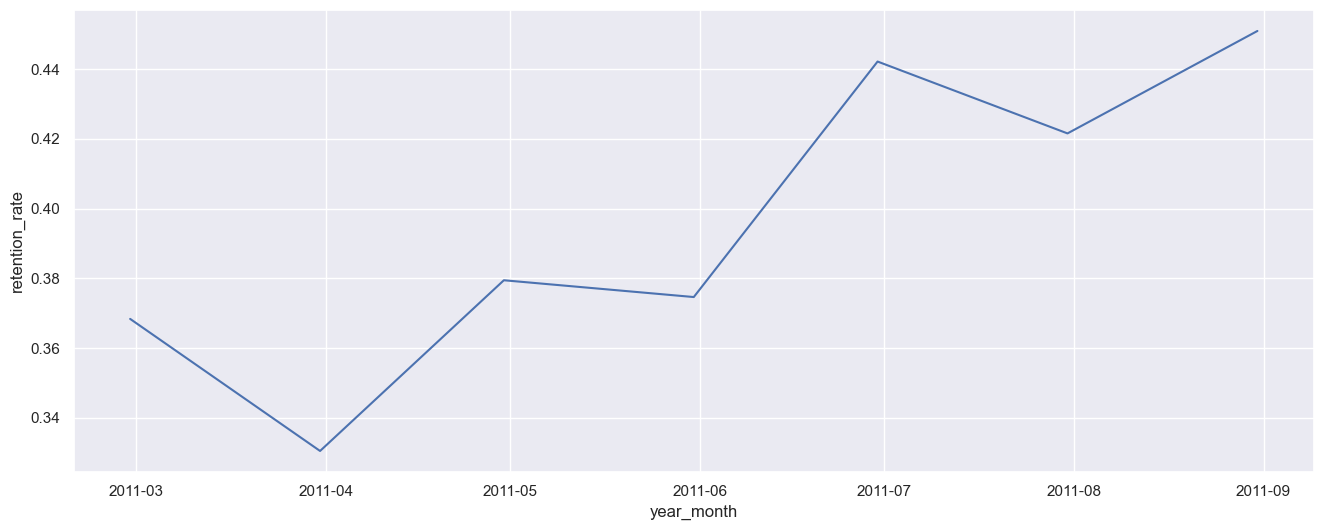

In [183]:
sns.lineplot(data=retention_df, x='year_month', y='retention_rate')

### Cohort Initial Retention Rate
Number of users retained after their first purchase (per month).  
How many users purchase the following month, given that their first purchase was the previous month.

In [184]:
# Months in which the following purchase may occur in order to be considered retained
cohort = 1
cohort_mes = []
# Date of first purchase
primera_compra = crevenue.groupby(['CustomerID','cluster_6'], as_index=False)['year_month'].min()
primera_compra.rename(columns={'year_month':'cohort_begg'},inplace=True)
primera_compra


,CustomerID,cluster_6,cohort_begg
0,12346,c0,2011-01-31
1,12747,c1,2010-12-31
2,12748,c2,2010-12-31
3,12749,c4,2011-05-31
4,12820,c0,2011-01-31
...,...,...,...
3022,18280,c5,2011-03-31
3023,18281,c3,2011-06-30
3024,18282,c2,2011-08-31
3025,18283,c1,2011-01-31


In [185]:
crevenue.head(2)

,CustomerID,year_month,cluster_6,revenue
0,12346,2011-01-31,c0,0.00
1,12747,2010-12-31,c1,706.27


In [186]:
for c in range(1,12):
  cohort_retention = crevenue.sort_values('year_month', ascending=True).groupby(['CustomerID',
                      'cluster_6']).head(cohort + c).sort_values(['CustomerID','year_month'])
  cohort_retention = cohort_retention[['CustomerID', 'year_month', 'cluster_6']]
  # keep only the dates of purchase within of the sale of the cohort
  cohort_retention = cohort_retention.merge(primera_compra, on='CustomerID')
  cohort_retention['cohort_end'] = cohort_retention['cohort_begg'] + pd.DateOffset(months=c)
  cohort_retention = cohort_retention[cohort_retention['year_month'] <= cohort_retention['cohort_end']]
  # retain detected
  del cohort_retention['cluster_6_y']
  cohort_retention.rename(columns={'cluster_6_x':'cluster_6'}, inplace=True)
  compradores = cohort_retention.groupby(['CustomerID', 'cluster_6'], as_index=False)['year_month'].count()
  retenidos_cohort = compradores[compradores['year_month']>1]
  # Create df with the window of the cohort
  total_retenidos = retenidos_cohort['CustomerID'].shape[0] / compradores['CustomerID'].shape[0]
  df_ = pd.DataFrame({'cohort':[c], 'retencion':[total_retenidos]})
  cohort_mes.append(df_)

cohort_mes = pd.concat(cohort_mes, ignore_index=True)
cohort_mes

,cohort,retencion
0,1,0.190948
1,2,0.355137
2,3,0.431450
3,4,0.496531
4,5,0.534192
5,6,0.554014
6,7,0.568219
7,8,0.573505
8,9,0.573505
9,10,0.573505


In [187]:
#change the date of the month and year by a numeric identifier
crevenue['mes_int'] = crevenue['year_month'].apply(lambda x: x.year*100 + x.month)
crevenue['mes_int'].unique()

array([201101, 201012, 201103, 201105, 201106, 201108, 201102, 201104,
       201107], dtype=int64)

In [188]:
crevenue

,CustomerID,year_month,cluster_6,revenue,mes_int
0,12346,2011-01-31,c0,0.00,201101
1,12747,2010-12-31,c1,706.27,201012
2,12747,2011-01-31,c1,303.04,201101
3,12747,2011-03-31,c1,310.78,201103
4,12747,2011-05-31,c1,771.31,201105
...,...,...,...,...,...
7698,18283,2011-04-30,c1,117.68,201104
7699,18283,2011-05-31,c1,99.47,201105
7700,18283,2011-06-30,c1,307.53,201106
7701,18283,2011-07-31,c1,143.19,201107


In [189]:
df_retention = pd.crosstab(crevenue['CustomerID'], crevenue['mes_int']).reset_index()
first_purchase = crevenue.groupby(['CustomerID', 'cluster_6'], as_index=False)['mes_int'].min()
first_purchase.rename(columns={'mes_int':'first_purchase'}, inplace=True)

df_retention = pd.merge(df_retention, first_purchase[['CustomerID','first_purchase', 
                                                      'cluster_6']],on='CustomerID')
cols = list(df_retention.columns[:-2])
cols.append('first_purchase')
cols.append('cluster_6')
df_retention.columns = cols
df_retention


,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,first_purchase,cluster_6
0,12346,0,1,0,0,0,0,0,0,0,201101,c0
1,12747,1,1,0,1,0,1,1,0,1,201012,c1
2,12748,1,1,1,1,1,1,1,1,1,201012,c2
3,12749,0,0,0,0,0,1,0,0,1,201105,c4
4,12820,0,1,0,0,0,0,0,0,0,201101,c0
...,...,...,...,...,...,...,...,...,...,...,...,...
3022,18280,0,0,0,1,0,0,0,0,0,201103,c5
3023,18281,0,0,0,0,0,0,1,0,0,201106,c3
3024,18282,0,0,0,0,0,0,0,0,1,201108,c2
3025,18283,0,1,1,0,1,1,1,1,0,201101,c1


In [192]:
groups = df_retention['cluster_6'].unique()
groups

array(['c0', 'c1', 'c2', 'c4', 'c3', 'c5'], dtype=object)

In [191]:
df_retention[df_retention['cluster_6'] == groups[1]]

,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,first_purchase,cluster_6
1,12747,1,1,0,1,0,1,1,0,1,201012,c1
10,12830,0,0,0,0,0,0,1,1,0,201106,c1
17,12839,1,0,1,1,0,1,1,1,1,201012,c1
18,12840,0,0,0,0,1,1,1,1,0,201104,c1
21,12843,0,0,0,1,0,1,1,1,0,201103,c1
...,...,...,...,...,...,...,...,...,...,...,...,...
3006,18248,0,0,0,0,0,0,1,0,1,201106,c1
3010,18257,0,0,1,1,0,1,1,0,1,201102,c1
3012,18260,1,1,0,1,1,1,1,0,0,201012,c1
3019,18272,0,0,0,0,1,1,0,1,1,201104,c1


In [193]:
meses = df_retention['first_purchase'].sort_values().unique()
groups = df_retention['cluster_6'].unique()
for group in groups:
    retention_cohort = []
    for m, _ in enumerate(meses):
        retention_ = {}
        selected_month = meses[m]
        mes_actual = meses[m]
        meses_anteriores = meses[:m]
        meses_siguientes = meses[m+1:]

      
        for prev_month in meses_anteriores:
            retention_[prev_month] = np.nan

        df_retention_ = df_retention[df_retention['cluster_6'] == group] 
        usuarios_nuevos = df_retention_[df_retention_['first_purchase'] ==  int(mes_actual)]['first_purchase'].count()
        retention_['usuarios_nuevos'] = usuarios_nuevos
        retention_[mes_actual] = 1 
        
        query = "first_purchase == {}".format(mes_actual)
        

        for mes_siguiente in meses_siguientes:
            query_ = query + " and {} > 0".format(mes_siguiente)
            if usuarios_nuevos != 0:
                retention_[mes_siguiente] = df_retention_.query(query_)[mes_siguiente].sum()/usuarios_nuevos
            else:
                retention_[mes_siguiente] = np.nan
        
        retention_cohort.append(retention_)
    
    retention_cohort = pd.DataFrame(retention_cohort)
    retention_cohort.index = meses
    print('\n cluster: ' + group)
    print(retention_cohort)


 cluster: c0
        usuarios_nuevos  201012    201101    201102  201103  201104  201105  \
201012              228     1.0  0.105263  0.074561     0.0     0.0     0.0   
201101              109     NaN  1.000000  0.082569     0.0     0.0     0.0   
201102              115     NaN       NaN  1.000000     0.0     0.0     0.0   
201103                0     NaN       NaN       NaN     1.0     NaN     NaN   
201104                0     NaN       NaN       NaN     NaN     1.0     NaN   
201105                0     NaN       NaN       NaN     NaN     NaN     1.0   
201106                0     NaN       NaN       NaN     NaN     NaN     NaN   
201107                0     NaN       NaN       NaN     NaN     NaN     NaN   
201108                0     NaN       NaN       NaN     NaN     NaN     NaN   

        201106  201107  201108  
201012     0.0     0.0     0.0  
201101     0.0     0.0     0.0  
201102     0.0     0.0     0.0  
201103     NaN     NaN     NaN  
201104     NaN     NaN     NaN

In [194]:
usuarios[['cluster_6','sr','sm','sf']].groupby('cluster_6').mean()

,sr,sm,sf
cluster_6,,,
c0,0.889262,0.225240,0.026993
c1,0.047764,0.234386,0.633901
c2,0.003712,0.246728,0.968874
c3,0.309265,0.228224,0.225951
c4,0.106213,0.229970,0.383873
c5,0.575413,0.228115,0.115930


Given the metrics and the RMF model values for each cluster obtained in this analysis, it can be said that a good policy to keep customers in cluster **c0** who have recently interacted with the company, but do not make frequent purchases and their monetary contribution is moderate, is to send a message of thanks and recognition for their activity and offer discounts and exclusive promotions to encourage additional purchases.

A good policy to apply to cluster **c4** where customers have not recently interacted with the company, but have spent a reasonable amount of money and make purchases with some frequency, you can offer incentives such as special promotions to motivate this segment of customers to return to interact and make purchases.

The best policy to retain users with a view to canceling infrequent and moderate recency, such as the **c5** and even **c3** clusters, may be to offer them a subscription service where shipments per month are free.

A policy to maintain the **c2** cluster and retain these users who are valuable to the company due to their high monetary expenditure on our products and high frequency is to offer special discounts or rewards for their loyalty, this can be done through discount coupons on their next purchase.

The cluster **c1** can be applied a policy of promotions and provide exceptional customer service, this because the amount of purchases is high and their frequency in the company is also high, they are customers who should be kept happy with the products offered by the company.